# PLAN

1. Do Exploratory Data Analysis
2. Do data augmentation
3. Do image pre-processing

Now Data is analysed and ready

Things to try out:
Also for each one try freezing and unfreezing layers.
Also try for different graphic (28,64,128,224)

->Image Similarity Search
Take top k most similar and return based on majority voting
    ->Frozen ClipViT L/14 
    ->Frozen ClipViT B/32 
    ->SeResNext model and Faiss
    ->Hashing 

Try individual and ensemble(averaging, weighted, stacking) with below models
    ->CLIP ViT-H/14-quickgelu
    ->ConvNext-XXLarge
    ->CLIP ViT-B/32
    ->CLIP ViT-L/14
    ->CoCa
    ->CSWin


Do early stopping using val dataset

Also show F2 score

# Importing libraries and data

In [ ]:
!pip install medmnist

In [ ]:
! kaggle competitions download -c tensor-reloaded-multi-task-med-mnist

In [ ]:
#unzip file
! unzip tensor-reloaded-multi-task-med-mnist.zip

In [11]:
! pip install timm --upgrade

In [4]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from medmnist import INFO  # Contains dataset metadata
import medmnist          # This imports all available MedMNIST dataset classes
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# MedMNIST Dataset

In [36]:
import numpy as np
import torch
from torch.utils.data import Dataset

class MyMedNISTDataset(Dataset):
    def __init__(self, npz_path, split='train', transform=None):
        """
        Args:
            npz_path (str): Path to the .npz file (e.g. "./data/pathmnist.npz").
            split (str): Which split to load ("train", "val", or "test").
            transform (callable, optional): Optional transform to apply to each image.
        """
        super().__init__()
        self.split = split
        self.transform = transform
        
        # Load data from .npz using NumPy
        data_dict = np.load(npz_path)
        
        # Based on the chosen split, pick the corresponding arrays
        if split == 'train':
            self.images = data_dict['train_images']
            self.labels = data_dict['train_labels']
        elif split == 'val':
            self.images = data_dict['val_images']
            self.labels = data_dict['val_labels']
        elif split == 'test':
            self.images = data_dict['test_images']
            self.labels = data_dict['test_labels']
        else:
            raise ValueError(f"Unknown split: {split} (expected 'train', 'val', or 'test')")
        
        # Convert labels to a 1D array if necessary (depends on how .npz is stored)
        self.labels = np.squeeze(self.labels)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # If images are grayscale (H, W), add channel dimension; if they are (H, W, C), rearrange to (C, H, W)
        # Example fix for grayscale: image = np.expand_dims(image, axis=-1)
        
        # Convert to float32 to avoid type issues
        image = image.astype(np.float32)
        
        # Optional: transform using torchvision or custom transformations
        if self.transform:
            # If your transform expects a PIL image, you might need to convert
            # image = Image.fromarray(image)
            image = self.transform(image)
        
        return image, label


In [40]:
info=INFO['breastmnist']
info

{'python_class': 'BreastMNIST',
 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/breastmnist.npz?download=1',
 'MD5': '750601b1f35ba3300ea97c75c52ff8f6',
 'url_64': 'https://zenodo.org/records/10519652/files/breastmnist_64.npz?download=1',
 'MD5_64': '742edef2a1fd1524b2efff4bd7ba9364',
 'url_128': 'https://zenodo.org/records/10519652/files/breastmnist_128.npz?download=1',
 'MD5_128': '363e4b3f8d712e9b5de15470a2aaadf1',
 'url_224': 'https://zenodo.org/records/10519652/files/breastmnist_224.npz?download=1',
 'MD5_224

In [38]:
dataset_keys = [
    'breastmnist',
    'dermamnist',
    'octmnist',
    'organamnist',
    'organcmnist',
    'organsmnist',
    'pathmnist',
    'pneumoniamnist',
    'retinamnist',
    'tissuemnist',
    'bloodmnist'
]

def get_transforms(n_channels):
    # If not 3 channels, first convert to 3 channels; otherwise, use identity.
    convert = transforms.Grayscale(num_output_channels=3) if n_channels != 3 else lambda x: x

    train_transform = transforms.Compose([
        convert,
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

    test_transform = transforms.Compose([
        convert,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    val_transform = test_transform

    return train_transform, val_transform, test_transform

# EXAMPLE USAGE
# for key in dataset_keys:
#     info = INFO[key]
#     n_channels = info.get('n_channels', 1)
#     npz_path = f"./data/{key}.npz"
#     train_dataset = MyMedNISTDataset(
#         npz_path=npz_path,
#         split='train',
#         transform=get_transforms(n_channels)[0]
#     )
#     print(f"Train {key} size:", len(train_dataset))

# Create a DataLoader to batch and shuffle
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Train breastmnist size: 546
Train dermamnist size: 7007
Train octmnist size: 97477
Train organamnist size: 34581
Train organcmnist size: 13000
Train organsmnist size: 13940
Train pathmnist size: 89996
Train pneumoniamnist size: 4708
Train retinamnist size: 1080
Train tissuemnist size: 165466
Train bloodmnist size: 11959


# Analysis and Pre-processing

In [18]:
dataset_keys = [
    'breastmnist',
    'dermamnist',
    'octmnist',
    'organamnist',
    'organcmnist',
    'organsmnist',
    'pathmnist',
    'pneumoniamnist',
    'retinamnist',
    'tissuemnist',
    'bloodmnist'
]


In [ ]:

data_transform = transforms.Compose([
    transforms.ToTensor()
])

# Loop over each dataset and download train & test splits
total_train_samples = 0
for key in dataset_keys:
    print(f"\nDownloading dataset: {key}.npz")
    
    # Retrieve dataset metadata from INFO and get the corresponding dataset class
    info = INFO[key]
    DataClass = getattr(medmnist, info['python_class'])
    
    # Download the train and test splits with the desired transformation and size.
    # mmap_mode='r' uses memory mapping in read-only mode.
    train_dataset = DataClass(
        split='train',
        transform=data_transform,
        download=True,
        size=28,
        mmap_mode='r'
    )
    
    test_dataset = DataClass(
        split='test',
        transform=data_transform,
        download=True,
        size=28,
        mmap_mode='r'
    )
    
    # Optionally, wrap datasets in DataLoaders (here just to print the number of samples)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    total_train_samples += len(train_dataset)
    print(f"-> {key}: {len(train_dataset)} training samples, {len(test_dataset)} testing samples")


print(f"\nTotal training samples: {total_train_samples}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.58431375].


Dataset: breastmnist 
Shape of image: (3, 28, 28)
    Number of channels: 3
    Number of samples: {'train': 546, 'val': 78, 'test': 156}

Unique labels in train dataset:
    Label 0: 147 (26.92%)
    Label 1: 399 (73.08%)


Total number of train labels: 546


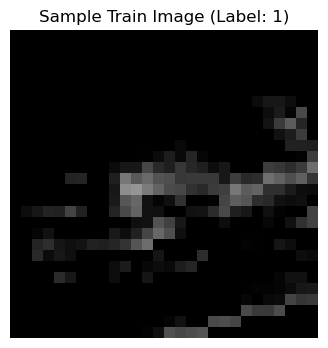

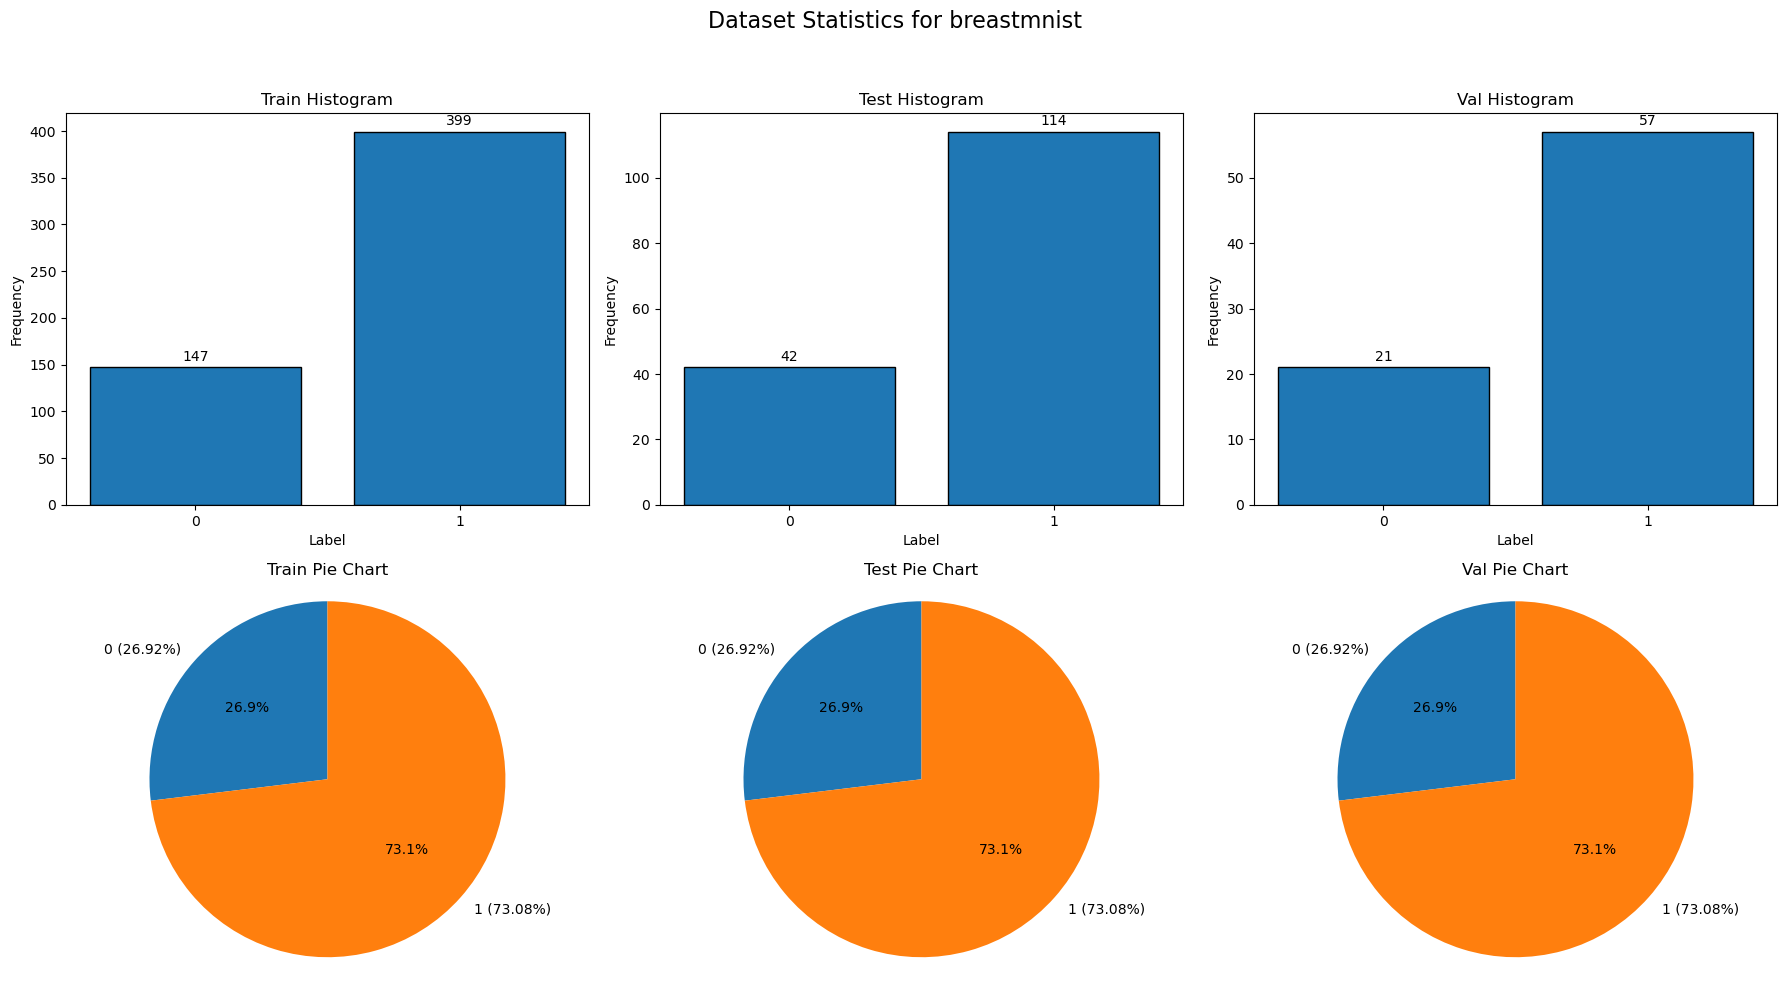



Dataset: dermamnist 
Shape of image: (3, 28, 28)
    Number of channels: 3
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39005598..1.7694151].



Unique labels in train dataset:
    Label 0: 228 (3.25%)
    Label 1: 359 (5.12%)
    Label 2: 769 (10.97%)
    Label 3: 80 (1.14%)
    Label 4: 779 (11.12%)
    Label 5: 4693 (66.98%)
    Label 6: 99 (1.41%)


Total number of train labels: 7007


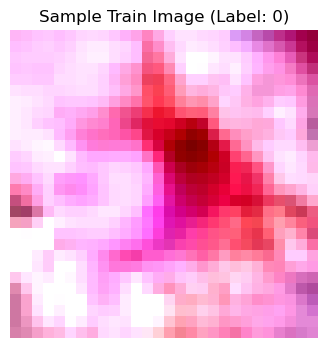

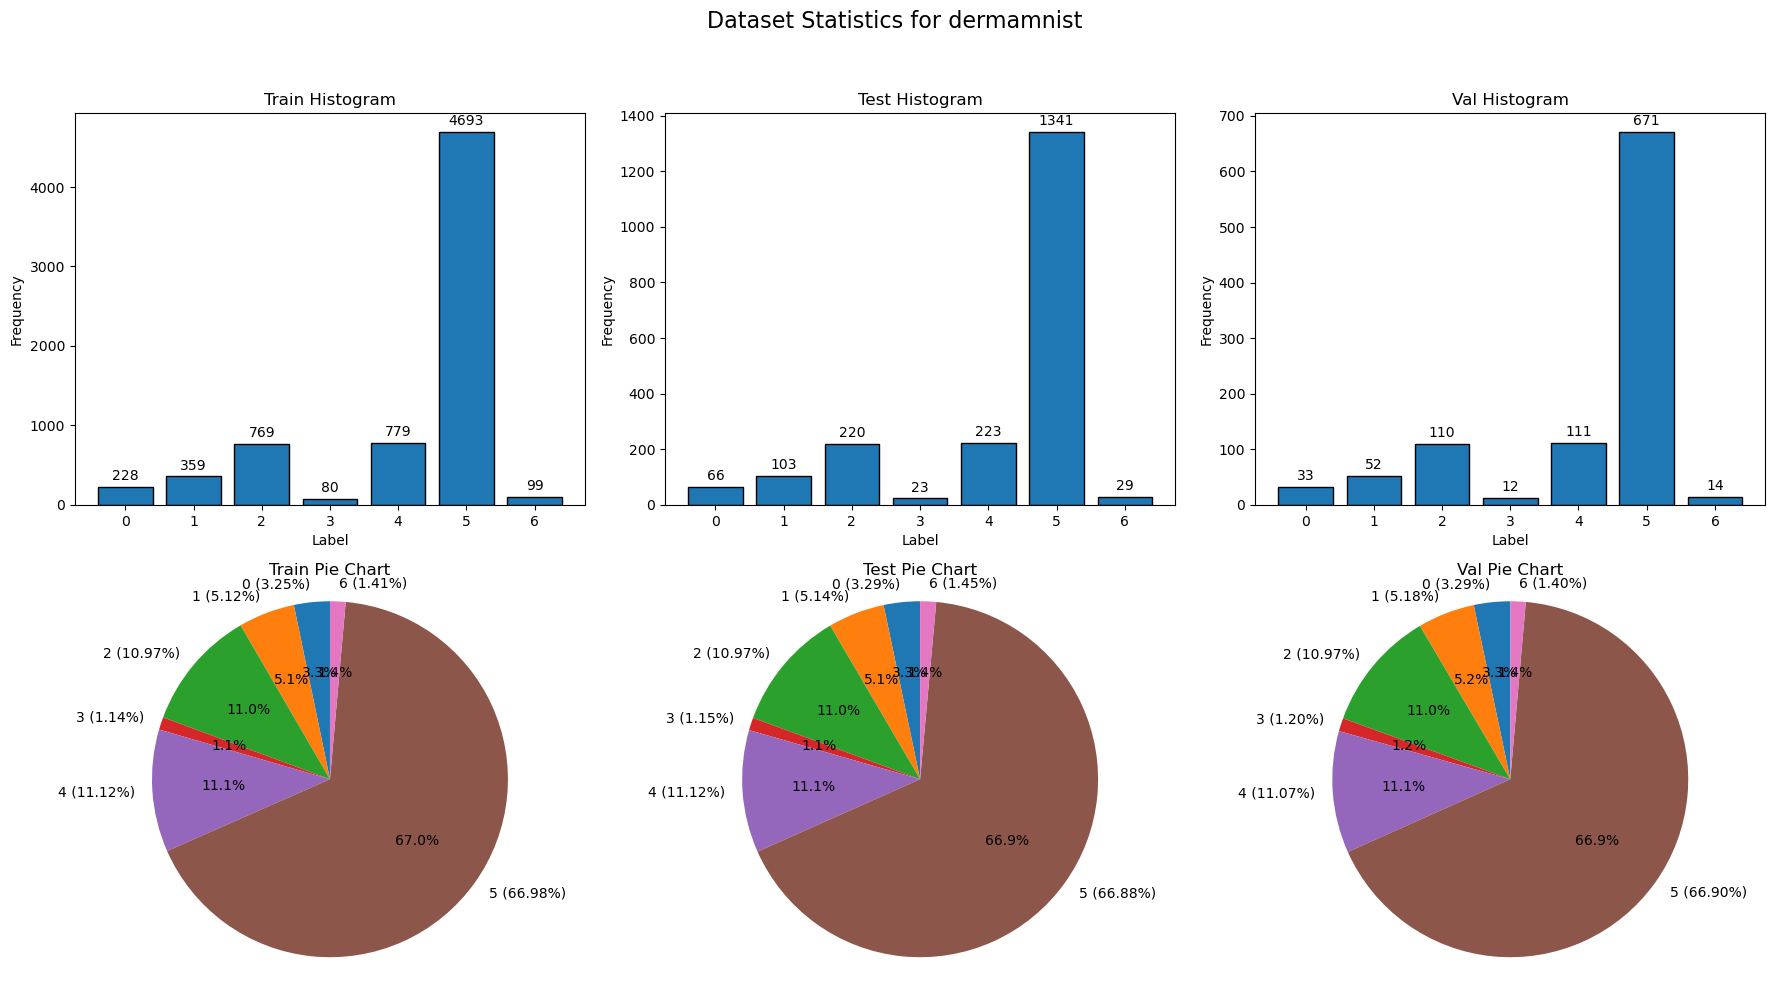



Dataset: octmnist 
Shape of image: (3, 28, 28)
    Number of channels: 3
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.18431377].



Unique labels in train dataset:
    Label 0: 33484 (34.35%)
    Label 1: 10213 (10.48%)
    Label 2: 7754 (7.95%)
    Label 3: 46026 (47.22%)


Total number of train labels: 97477


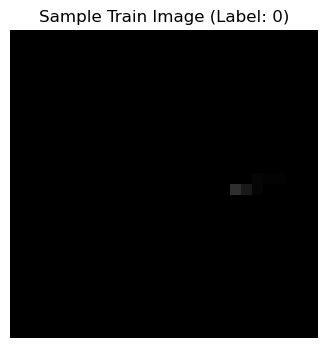

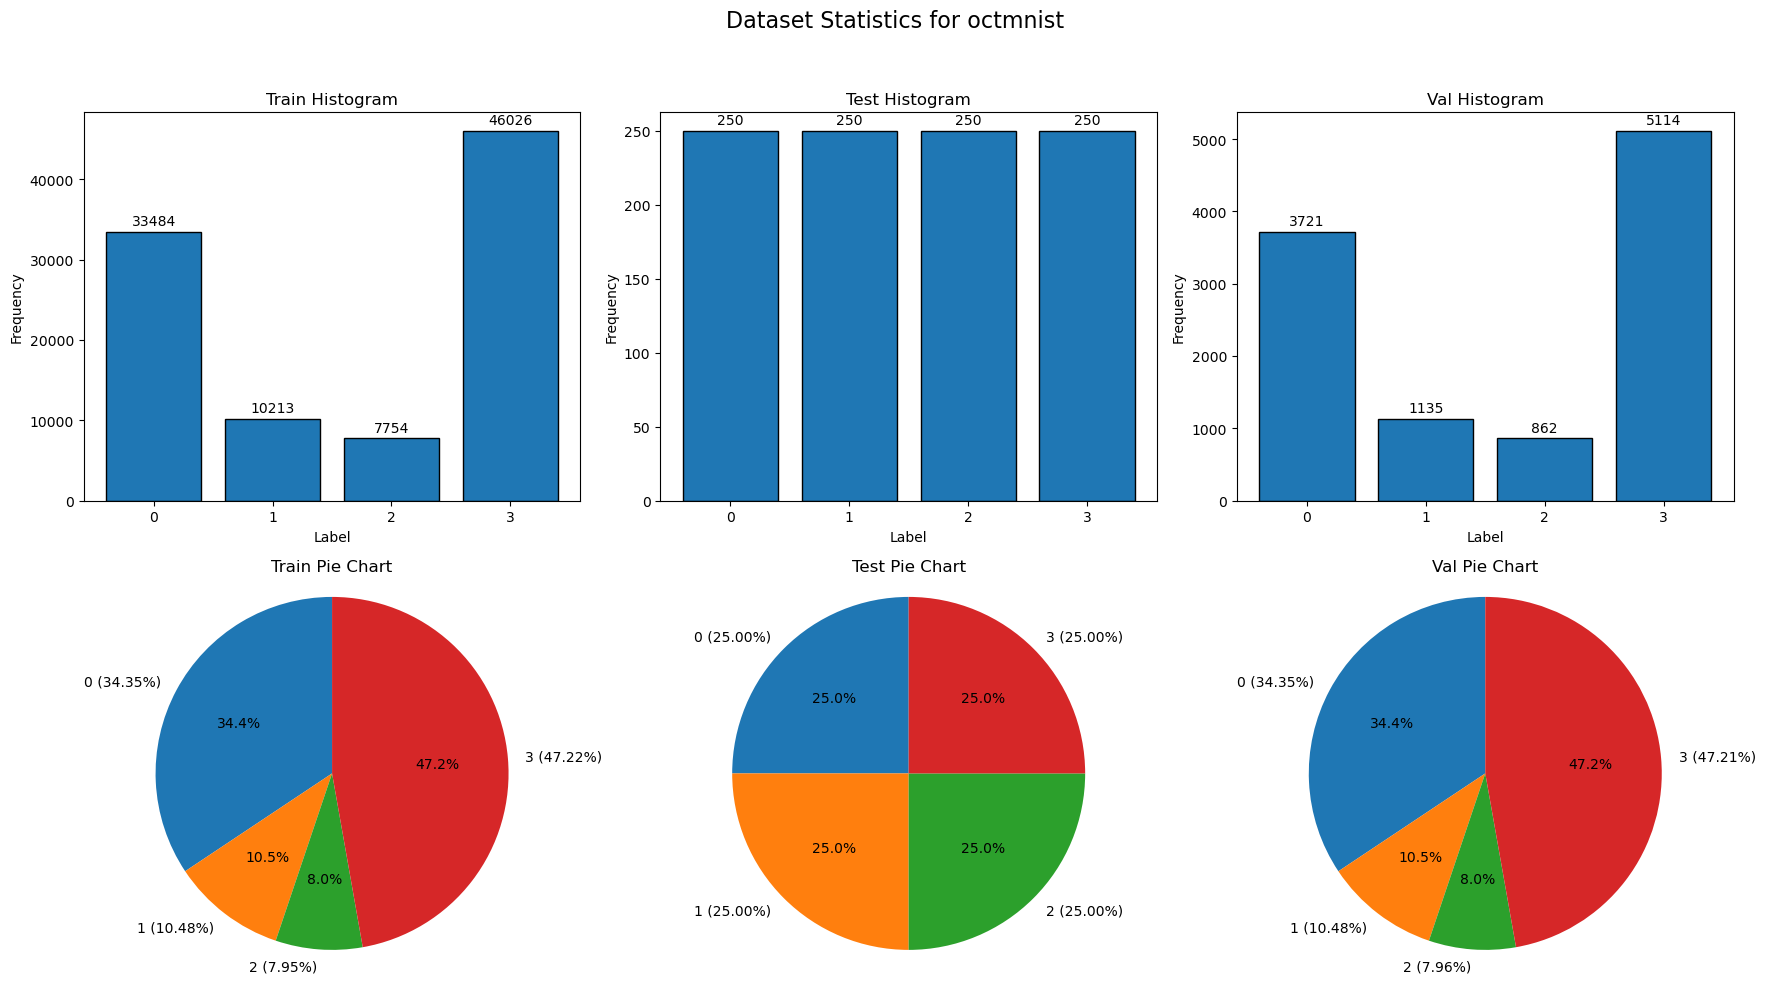



Dataset: organamnist 


AssertionError: 

In [23]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_dataset_statistics(dataset_key, dataset):
    # --- Print Dataset Metadata ---
    # Use provided keys from the dataset dictionary if available.
   
    train_data = dataset.get('train', [])
    val_data   = dataset.get('val', [])
    test_data  = dataset.get('test', [])
    
    print(f"Dataset: {dataset_key} ")
    
    # If train_data exists, extract the shape of the first image and number of channels.
    if len(train_data) > 0:
        first_image, first_label = train_data[0]
        print(f"Shape of image: {tuple(first_image.shape)}")

        # Assuming image shape is like (channels, height, width)
        num_channels = first_image.shape[0] if len(first_image.shape) > 0 else 'N/A'
        print(f"    Number of channels: {num_channels}")
    else:
        print("    No train data available to inspect image shape and channels.")
    
    print(f"    Number of samples: {{'train': {len(train_data)}, 'val': {len(val_data)}, 'test': {len(test_data)}}}")

    
    # --- Print Unique Label Info for the Train Split ---
    if len(train_data) > 0:
        train_labels = [train_data[i][1].item() for i in range(len(train_data))]
        train_counter = Counter(train_labels)
        unique_train_labels = sorted(train_counter.keys())
        counts_train = [train_counter[label] for label in unique_train_labels]
        print("\nUnique labels in train dataset:")
        total_train = len(train_data)
        for label, count in zip(unique_train_labels, counts_train):
            print(f"    Label {label}: {count} ({count / total_train * 100:.2f}%)")
    print("\n")

    #print total number of train labels not unique
    print(f"Total number of train labels: {len(train_labels)}")
    
    if len(train_data) > 0:
        first_image, first_label = train_data[0]
        # If the image has one channel, squeeze it and use grayscale colormap.
        if first_image.shape[0] == 1:
            # Remove the channel dimension.
            img = first_image.squeeze()
            cmap = 'gray'
        else:
            # Rearrange dimensions from (channels, height, width) to (height, width, channels)
            img = first_image.permute(1, 2, 0)
            cmap = None
        
        plt.figure(figsize=(4, 4))
        plt.imshow(img, cmap=cmap)
        plt.title(f"Sample Train Image (Label: {first_label.item()})")
        plt.axis('off')
        plt.show()
    # --- Create a 2x3 subplot layout for histograms and pie charts ---
    splits = ['train', 'test', 'val']
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"Dataset Statistics for {dataset_key}", fontsize=16)
    
    # Loop over each split and create a bar chart and a pie chart.
    for idx, split in enumerate(splits):
        data = dataset.get(split, [])
        ax_bar = axes[0, idx]  # Bar chart (histogram) in first row.
        ax_pie = axes[1, idx]  # Pie chart in second row.
        
        if len(data) == 0:
            # If there is no data, display a message in both axes.
            for ax in (ax_bar, ax_pie):
                ax.text(0.5, 0.5, f"No {split} data", horizontalalignment='center',
                        verticalalignment='center', transform=ax.transAxes, fontsize=14)
                ax.axis('off')
            continue
        
        # Extract labels (assuming each data point is a tuple: (image, label))
        labels = [data[i][1].item() for i in range(len(data))]
        label_counter = Counter(labels)
        unique_labels = sorted(label_counter.keys())
        counts = [label_counter[label] for label in unique_labels]
        


        # --------------------- #
        # Plot Bar Chart (Histogram)
        # --------------------- #
        bars = ax_bar.bar(unique_labels, counts, edgecolor='black')
        ax_bar.set_title(f"{split.capitalize()} Histogram")
        ax_bar.set_xlabel("Label")
        ax_bar.set_ylabel("Frequency")
        ax_bar.set_xticks(unique_labels)
        ax_bar.set_xticklabels([str(label) for label in unique_labels])
        
        # Annotate each bar with its count.
        vertical_offset = max(counts) * 0.01 if max(counts) > 0 else 1
        for bar in bars:
            height = bar.get_height()
            ax_bar.text(
                bar.get_x() + bar.get_width() / 2,
                height + vertical_offset,
                f'{int(height)}',
                ha='center',
                va='bottom'
            )
        
        # --------------------- #
        # Plot Pie Chart
        # --------------------- #
        # Prepare labels that include the percentage.
        labels_with_percent = [
            f"{label} ({count / len(data) * 100:.2f}%)"
            for label, count in zip(unique_labels, counts)
        ]
        ax_pie.pie(counts, labels=labels_with_percent, autopct='%1.1f%%', startangle=90)
        ax_pie.set_title(f"{split.capitalize()} Pie Chart")
        ax_pie.axis('equal')  # Ensures the pie chart is circular.
    
    # Adjust layout to prevent overlapping.
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    print("\n")

for key in dataset_keys:
    plot_dataset_statistics(key, datasets[key])

In [7]:
import numpy as np
task_classes = {}

for key in dataset_keys:
    train_labels = datasets[key]['train'].labels
    unique_labels = np.unique(train_labels)
    task_classes[key] = len(unique_labels)

task_classes

{'breastmnist': 2,
 'dermamnist': 7,
 'octmnist': 4,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'pathmnist': 9,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'tissuemnist': 8,
 'bloodmnist': 8}

# Custom basic CNN model with multiple MLP Heads (28x28 images) score of 8.2 (very bad)

In [196]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiTaskCNN(nn.Module):
    def __init__(self, task_classes_dict):
        """
        Args:
            task_classes_dict (dict): A dictionary mapping task names to number of output classes.
                                       For example: {"bloodmnist": 8, "pathmnist": 9}
        """
        super(MultiTaskCNN, self).__init__()
        # Shared CNN backbone for 3x28x28 input images
        # Conv Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # 3x28x28 -> 32x28x28
        self.bn1   = nn.BatchNorm2d(32)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)                              # 32x28x28 -> 32x14x14
        
        # Conv Block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # 32x14x14 -> 64x14x14
        self.bn2   = nn.BatchNorm2d(64)
        # Pool again: 64x14x14 -> 64x7x7
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv Block 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # 64x7x7 -> 128x7x7
        self.bn3   = nn.BatchNorm2d(128)
        
        # Conv Block 4
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # 128x7x7 -> 256x7x7
        self.bn4   = nn.BatchNorm2d(256)
        
        # Global average pooling: outputs (batch_size, 256, 1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_dim = 256  # number of channels after pooling
        
        # Task-specific MLP heads
        # Each head is a small MLP: Linear(feature_dim, 128) -> ReLU -> Linear(128, num_classes)
        self.task_heads = nn.ModuleDict({
            task: nn.Sequential(
                nn.Linear(self.feature_dim, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes)
            ) for task, num_classes in task_classes_dict.items()
        })

    def forward(self, x, task):
        # Shared CNN backbone
        x = F.relu(self.bn1(self.conv1(x)))  # (B, 32, 28, 28)
        x = self.pool(x)                     # (B, 32, 14, 14)
        x = F.relu(self.bn2(self.conv2(x)))  # (B, 64, 14, 14)
        x = self.pool2(x)                    # (B, 64, 7, 7)
        x = F.relu(self.bn3(self.conv3(x)))  # (B, 128, 7, 7)
        x = F.relu(self.bn4(self.conv4(x)))  # (B, 256, 7, 7)
        x = self.avgpool(x)                  # (B, 256, 1, 1)
        x = x.view(x.size(0), -1)            # Flatten to (B, 256)
        
        # Use the appropriate task head
        if task not in self.task_heads:
            raise ValueError(f"Task '{task}' not found. Available tasks: {list(self.task_heads.keys())}")
        logits = self.task_heads[task](x)
        return logits


In [204]:
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def train_model(model, dataloader, optimizer, criterion, task, num_epochs=8, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
    
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Log original shapes before any squeezing
            # Uncomment the next two lines for debugging if needed:
            # print(f"Batch {batch_idx}: Original labels shape: {labels.shape}")
            # print(f"Batch {batch_idx}: Images shape: {images.shape}")

            # Squeeze the labels to remove extra dimensions
            labels = labels.squeeze()
            # After squeezing, if the labels tensor has no elements, skip this batch.
            if labels.numel() == 0 or labels.dim() == 0:
                print(f"Batch {batch_idx}: Skipping because labels tensor is empty after squeeze.")
                continue

            # Ensure labels are of type long
            labels = labels.long()

            # Debug print: check shapes after processing labels
            # print(f"Batch {batch_idx}: Processed labels shape: {labels.shape}")

            optimizer.zero_grad()
            outputs = model(images, task=task)
            
            # Debug print: show output shape and labels shape before loss calculation
            # print(f"Batch {batch_idx}: outputs shape: {outputs.shape}, labels shape: {labels.shape}")
            
            # Check if outputs and labels batch sizes match
            if outputs.size(0) != labels.size(0):
                print(f"Batch {batch_idx}: Mismatch! outputs batch size: {outputs.size(0)}, labels batch size: {labels.size(0)}")
                continue

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        if total > 0:
            epoch_loss = running_loss / total
            epoch_acc = correct / total
        else:
            epoch_loss, epoch_acc = 0, 0

        print(f"Task: {task} | Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")
        
        # # Optionally, evaluate on validation data at each epoch
        # val_acc, val_loss = evaluate_model(model, loaders[task]['val'], criterion, task, device=device, mode='val')
        # print(f"   Validation: Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")




import numpy as np
from sklearn.metrics import f1_score

def evaluate_model(model, dataloader, criterion, task, device='cpu', mode='test'):
    """
    Evaluate the model on the given dataloader for a specific task.
    Only prints three key metrics: Average Loss, Accuracy, and Macro F1 Score.
    
    Returns:
        A dictionary with keys 'avg_loss', 'accuracy', and 'macro_f1'.
    """
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Squeeze to remove extra dimensions.
            labels = labels.squeeze()
            if labels.numel() == 0 or labels.dim() == 0:
                # Skip the batch if labels are empty after squeeze.
                continue
            labels = labels.long()
            
            outputs = model(images, task=task)
            
            # If batch size mismatch occurs, skip the batch.
            if outputs.size(0) != labels.size(0):
                continue
            
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # If no samples were evaluated, return zeros.
    if total == 0:
        print(f"\n{mode.upper()} Metrics for task '{task}': No samples to evaluate!")
        return {"avg_loss": 0, "accuracy": 0, "macro_f1": 0}
    
    avg_loss = running_loss / total
    accuracy_val = correct / total
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # Print the three key metrics.
    print(f"\n{mode.upper()} Metrics for task '{task}':")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy_val:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    
    return {"avg_loss": avg_loss, "accuracy": accuracy_val, "macro_f1": macro_f1}


In [219]:
# Instantiate model using our task_classes dictionary:
model = MultiTaskCNN(task_classes_dict=task_classes)
# --- Step 4: Set Up Optimizer and Loss Function ---
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")
    

model.to(device)

Using MPS device


MultiTaskCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (task_heads): ModuleDict(
    (breastmnist): Sequential(
      (0): Linear(in_features=256, ou

In [220]:
for task in dataset_keys:
    print(f"\n--- Training on {task.upper()} ---")
    #print size of training samples
    print(f"Size of training samples: {len(datasets[task]['train'])}")
    # Train for a few epochs (e.g., 10 epochs) using the train DataLoader for that task
    train_model(model, loaders[task]['train'], optimizer, criterion, task, num_epochs=8, device=device)



--- Training on BREASTMNIST ---
Size of training samples: 546
Task: breastmnist | Epoch [1/8] | Loss: 0.5791 | Accuracy: 0.6685
Task: breastmnist | Epoch [2/8] | Loss: 0.5001 | Accuracy: 0.7509
Task: breastmnist | Epoch [3/8] | Loss: 0.4878 | Accuracy: 0.7949
Task: breastmnist | Epoch [4/8] | Loss: 0.4675 | Accuracy: 0.7875
Task: breastmnist | Epoch [5/8] | Loss: 0.4615 | Accuracy: 0.8077
Task: breastmnist | Epoch [6/8] | Loss: 0.4558 | Accuracy: 0.8077
Task: breastmnist | Epoch [7/8] | Loss: 0.4338 | Accuracy: 0.7967
Task: breastmnist | Epoch [8/8] | Loss: 0.4056 | Accuracy: 0.8260

--- Training on DERMAMNIST ---
Size of training samples: 7007
Task: dermamnist | Epoch [1/8] | Loss: 0.9479 | Accuracy: 0.6716
Task: dermamnist | Epoch [2/8] | Loss: 0.8297 | Accuracy: 0.6910
Task: dermamnist | Epoch [3/8] | Loss: 0.8082 | Accuracy: 0.6949
Task: dermamnist | Epoch [4/8] | Loss: 0.7819 | Accuracy: 0.7090
Task: dermamnist | Epoch [5/8] | Loss: 0.7486 | Accuracy: 0.7181
Task: dermamnist | Ep

In [222]:
from scipy.stats import hmean

# Assume 'dataset_keys' is a list of your task names.
# And that for each task you call evaluate_model which returns a dictionary.
task_macro_f1 = {}

for task in dataset_keys:
    print(f"\n--- Evaluating on {task.upper()} ---")
    metrics = evaluate_model(model, loaders[task]['test'], criterion, task, device=device, mode='test')
    task_macro_f1[task] = metrics["macro_f1"]

# Compute the overall harmonic mean of the macro F1 scores:
if task_macro_f1:
    overall_hmean = hmean(list(task_macro_f1.values()))
    print(f"\nOverall Harmonic Mean of Macro F1 Scores: {overall_hmean:.4f}")
else:
    print("No macro F1 scores available.")



--- Evaluating on BREASTMNIST ---

TEST Metrics for task 'breastmnist':
Average Loss: 1.1860
Accuracy: 0.7308
Macro F1 Score: 0.4222

--- Evaluating on DERMAMNIST ---

TEST Metrics for task 'dermamnist':
Average Loss: 1.4754
Accuracy: 0.6688
Macro F1 Score: 0.1145

--- Evaluating on OCTMNIST ---

TEST Metrics for task 'octmnist':
Average Loss: 5.3518
Accuracy: 0.1670
Macro F1 Score: 0.1113

--- Evaluating on ORGANAMNIST ---

TEST Metrics for task 'organamnist':
Average Loss: 13.7596
Accuracy: 0.1174
Macro F1 Score: 0.0346

--- Evaluating on ORGANCMNIST ---

TEST Metrics for task 'organcmnist':
Average Loss: 8.7615
Accuracy: 0.1436
Macro F1 Score: 0.0408

--- Evaluating on ORGANSMNIST ---

TEST Metrics for task 'organsmnist':
Average Loss: 9.7727
Accuracy: 0.1145
Macro F1 Score: 0.0386

--- Evaluating on PATHMNIST ---

TEST Metrics for task 'pathmnist':
Average Loss: 7.0766
Accuracy: 0.1836
Macro F1 Score: 0.1116

--- Evaluating on PNEUMONIAMNIST ---

TEST Metrics for task 'pneumoniamn

In [230]:
import pandas as pd
import torch

# Set device and ensure model is in evaluation mode.
model.eval()

submission_entries = []  # List to store each row as a dictionary.
global_id = 0  # Global submission id that increases across tasks.

# Iterate over each task in your dataset_keys.
for task in dataset_keys:
    print(f"Processing test set for task: {task}")
    id_image_in_task = 0  # Reset the task-specific image id counter.
    
    # Loop over the test DataLoader for the current task.
    with torch.no_grad():
        for images, _ in loaders[task]['test']:
            images = images.to(device)
            outputs = model(images, task=task)
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu().numpy()
            
            # For each image in the batch, create a submission row.
            for pred in predicted:
                submission_entries.append({
                    "id": global_id,
                    "id_image_in_task": id_image_in_task,
                    "task_name": task,
                    "label": int(pred)
                })
                global_id += 1
                id_image_in_task += 1

# For tasks "organcmnist" and "organsmnist", add extra rows if needed.
# Expected test sizes:
expected_counts = {"organcmnist": 8268, "organsmnist": 8829}

for task, expected_count in expected_counts.items():
    # Count the current rows for the task.
    current_count = sum(1 for row in submission_entries if row["task_name"] == task)
    missing = expected_count - current_count
    if missing > 0:
        print(f"Task '{task}' is missing {missing} rows. Appending extra rows...")
        # Determine the next id_image_in_task for this task.
        # (Alternatively, you can reset it to 0 if required.)
        next_id = current_count
        for i in range(missing):
            submission_entries.append({
                "id": global_id,
                "id_image_in_task": next_id + i,
                "task_name": task,
                "label": 0  # Use a default dummy label (modify if needed)
            })
            global_id += 1

# Create a pandas DataFrame with the required columns.
submission_df = pd.DataFrame(submission_entries, columns=["id", "id_image_in_task", "task_name", "label"])

# Save the DataFrame to a CSV file with a header.
submission_df.to_csv("TReloaded_3.csv", index=False)

print("Submission file created: submission.csv")


Processing test set for task: breastmnist
Processing test set for task: dermamnist
Processing test set for task: octmnist
Processing test set for task: organamnist
Processing test set for task: organcmnist
Processing test set for task: organsmnist
Processing test set for task: pathmnist
Processing test set for task: pneumoniamnist
Processing test set for task: retinamnist
Processing test set for task: tissuemnist
Processing test set for task: bloodmnist
Task 'organcmnist' is missing 52 rows. Appending extra rows...
Task 'organsmnist' is missing 2 rows. Appending extra rows...
Submission file created: submission.csv


In [231]:
#check dimension of /Users/home/Documents/pytorch-test/TReloaded_1.csv
import pandas as pd
df = pd.read_csv('TReloaded_3.csv')
df.shape

(96941, 4)

# Frozen Resnet18 backbone, simple MLP heads, early stopping score of 
# ResNet18= 59.4 (OK)
# Resnet50= 

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiTaskResNet(nn.Module):
    def __init__(self, task_outputs, backbone='resnet18', pretrained=True):
        """
        Args:
            task_outputs (dict): Mapping from task names to number of output classes.
                                 e.g. {"breastmnist": 2, "pathmnist": 9, ...}
            backbone (str): Which ResNet to use ('resnet18' or 'resnet50').
            pretrained (bool): If True, load pretrained weights.
        """
        super(MultiTaskResNet, self).__init__()
        
        if backbone == 'resnet18':
            resnet = models.resnet18(pretrained=pretrained)
            self.feat_dim = 512
        elif backbone == 'resnet50':
            resnet = models.resnet50(pretrained=pretrained)
            self.feat_dim = 2048
        else:
            raise ValueError("Unsupported backbone")
        
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # (B, feat_dim, 1, 1)
        for param in self.backbone.parameters():
            param.requires_grad = False  # freeze backbone
        
        # Each task gets its own head (an MLP) that projects features and outputs logits.
        self.task_outputs = task_outputs
        self.heads = nn.ModuleDict({
            task: nn.Sequential(
                nn.Flatten(),  # from (B, feat_dim, 1, 1) to (B, feat_dim)
                nn.Linear(self.feat_dim, 256),
                nn.ReLU(),
                nn.Linear(256, num_classes)
            ) for task, num_classes in self.task_outputs.items()
        })
    
    def forward(self, x, task):
        features = self.backbone(x)  # (B, feat_dim, 1, 1)
        features = features.view(features.size(0), -1)  # (B, feat_dim)
        if task not in self.heads:
            raise ValueError(f"Task '{task}' not found. Available tasks: {list(self.heads.keys())}")
        out = self.heads[task](features)
        return out


In [8]:
def train_model(model, train_loader, val_loader, optimizer, criterion, task, max_epochs=7, patience=2, device='cpu'):
    model.to(device)
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # If labels shape is [B, 1], squeeze dimension 1.
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            
            optimizer.zero_grad()
            outputs = model(images, task=task)
            if outputs.size(0) != labels.size(0):
                continue
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / total if total > 0 else 0
        train_acc = correct / total if total > 0 else 0
        print(f"Task: {task} | Epoch [{epoch+1}/{max_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        
        # Evaluate on validation set
        val_metrics = evaluate_model(model, val_loader, criterion, task, device=device, mode='val')
        val_loss = val_metrics["avg_loss"]
        
        print(f"Task: {task} | Epoch [{epoch+1}/{max_epochs}] | Val Loss: {val_loss:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict()
        elif epoch - best_epoch >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
            break
    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model


In [9]:
from sklearn.metrics import f1_score, fbeta_score

def evaluate_model(model, dataloader, criterion, task, device='cpu', mode='test'):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            
            outputs = model(images, task=task)
            if outputs.size(0) != labels.size(0):
                continue
            
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    avg_loss = running_loss / total if total > 0 else 0
    accuracy_val = correct / total if total > 0 else 0
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0) if total > 0 else 0
    macro_f2 = fbeta_score(all_labels, all_preds, beta=2, average='macro', zero_division=0) if total > 0 else 0
    if mode=='test':
        print(f"\n{mode.upper()} Metrics for task '{task}':")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Accuracy: {accuracy_val:.4f}")
        print(f"Macro F1 Score: {macro_f1:.4f}")
        print(f"Macro F2 Score: {macro_f2:.4f}")
    
    return {"avg_loss": avg_loss, "accuracy": accuracy_val, "macro_f1": macro_f1, "macro_f2": macro_f2}


In [10]:
import gc
from torchvision import transforms
from torch.utils.data import DataLoader

# List of dataset keys.
dataset_keys = [
    'breastmnist',
    'dermamnist',
    'octmnist',
    'organamnist',
    'organcmnist',
    'organsmnist',
    'pathmnist',
    'pneumoniamnist',
    'retinamnist',
    'tissuemnist',
    'bloodmnist'
]

# Define your transforms (as in your code) for train, val, test.
def get_transforms(n_channels):
    # If not 3 channels, first convert to 3 channels; otherwise, use identity.
    convert = transforms.Grayscale(num_output_channels=3) if n_channels != 3 else lambda x: x

    train_transform = transforms.Compose([
        convert,
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

    test_transform = transforms.Compose([
        convert,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    val_transform = test_transform

    return train_transform, val_transform, test_transform

# Assume task_classes is defined for all tasks.

task_classes = {'breastmnist': 2,
 'dermamnist': 7,
 'octmnist': 4,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'pathmnist': 9,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'tissuemnist': 8,
 'bloodmnist': 8}



# Set device.
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the multi-task model using CLIP Vit B/32 as backbone.
# For this example, we assume a MultiTaskCLIP model exists.
# If not, you can modify the MultiTaskResNet model to load CLIP instead.
# For demonstration, I'll assume you have a model similar to MultiTaskCLIP defined.
# Here, we'll use MultiTaskResNet as a placeholder.
model = MultiTaskResNet(task_outputs=task_classes, backbone='resnet18', pretrained=True).to(device)
# (Replace above with your MultiTaskCLIP model if available.)

# Define optimizer and loss.
import torch.optim as optim
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()
# # Define scheduler for 5 epochs (max epochs = 7, but scheduler T_max can be set to 5 for fine tuning)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)


Using device: mps


In [22]:

# Dictionary to store evaluation metrics per task.
results = {}

for key in dataset_keys:
    print(f"\n=== Processing {key.upper()} ===")
    info = INFO[key]
    DataClass = getattr(medmnist, info['python_class'])
    n_channels = info.get('n_channels', 1)
    train_transform, val_transform, test_transform = get_transforms(n_channels)
    
    # Load only this dataset into memory.
    ds_train = DataClass(split='train', transform=train_transform, download=True, size=224, mmap_mode='r')
    ds_val   = DataClass(split='val', transform=val_transform, download=True, size=224, mmap_mode='r')
    ds_test  = DataClass(split='test', transform=test_transform, download=True, size=224, mmap_mode='r')
    
    print(f"Loaded {key} dataset. Train size: {len(ds_train)}, Val size: {len(ds_val)}, Test size: {len(ds_test)}")
    
    # Create DataLoaders.
    loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
    loader_val = DataLoader(ds_val, batch_size=64, shuffle=False)
    loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)
    
    # Train the model on this task using early stopping.
    model = train_model(model, loader_train, loader_val, optimizer, criterion, task=key, max_epochs=7, patience=2, device=device)
    
    # Evaluate the model on the test set.
    metrics = evaluate_model(model, loader_test, criterion, task=key, device=device, mode='test')
    results[key] = metrics
    
    # Free up memory for next dataset.
    del ds_train, ds_val, ds_test, loader_train, loader_val, loader_test
    torch.cuda.empty_cache()
    gc.collect()

# Print overall evaluation metrics for each task.
print("\n=== Overall Evaluation Metrics ===")
for key, metrics in results.items():
    print(f"{key.upper()} -> Loss: {metrics['avg_loss']:.4f}, Accuracy: {metrics['accuracy']:.4f}, Macro F1: {metrics['macro_f1']:.4f}, Macro F2: {metrics['macro_f2']:.4f}")



=== Processing BREASTMNIST ===
Loaded breastmnist dataset. Train size: 546, Val size: 78, Test size: 156
Task: breastmnist | Epoch [1/7] | Train Loss: 0.6563 | Train Acc: 0.7399
Task: breastmnist | Epoch [1/7] | Val Loss: 0.5665
Task: breastmnist | Epoch [2/7] | Train Loss: 0.5540 | Train Acc: 0.7289
Task: breastmnist | Epoch [2/7] | Val Loss: 0.5508
Task: breastmnist | Epoch [3/7] | Train Loss: 0.5017 | Train Acc: 0.7436
Task: breastmnist | Epoch [3/7] | Val Loss: 0.5149
Task: breastmnist | Epoch [4/7] | Train Loss: 0.4807 | Train Acc: 0.7637
Task: breastmnist | Epoch [4/7] | Val Loss: 0.4861
Task: breastmnist | Epoch [5/7] | Train Loss: 0.4972 | Train Acc: 0.8004
Task: breastmnist | Epoch [5/7] | Val Loss: 0.4644
Task: breastmnist | Epoch [6/7] | Train Loss: 0.4402 | Train Acc: 0.8150
Task: breastmnist | Epoch [6/7] | Val Loss: 0.4416
Task: breastmnist | Epoch [7/7] | Train Loss: 0.4305 | Train Acc: 0.8132
Task: breastmnist | Epoch [7/7] | Val Loss: 0.4636

TEST Metrics for task 'br

In [30]:
import statistics
macro_f1_scores = [metrics['macro_f1'] for metrics in results.values()]
hm_macro_f1 = statistics.harmonic_mean(macro_f1_scores)
print(f"\nHarmonic Mean of Macro F1 scores: {hm_macro_f1:.4f}")


Harmonic Mean of Macro F1 scores: 0.5940


In [ ]:
# save the model
# torch.save(model.state_dict(), './model_1.pth')
# print("Model Saved")

In [21]:
# model.load_state_dict(torch.load('./model_1.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# # Loop over each task in your dataset_keys to load the test dataset and evaluate the model.
# for task in dataset_keys:
#     print(f"\n--- Evaluating {task.upper()} ---")
    
#     # Get the dataset info and corresponding data class.
#     info = INFO[task]
#     DataClass = getattr(medmnist, info['python_class'])
#     n_channels = info.get('n_channels', 1)
    
#     # Get transforms using the provided function.
#     _, _, test_transform = get_transforms(n_channels)
    
#     # Load only the test split for this task (using mmap_mode to help with RAM usage).
#     ds_test = DataClass(split='test', transform=test_transform, download=True, size=224, mmap_mode='r')
#     loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)
    
#     print(f"Loaded {task} test dataset with {len(ds_test)} samples.")
    
#     # Ensure the model is in evaluation mode.
#     model.eval()
    
#     # Evaluate using your previously defined evaluate_model function.
#     metrics = evaluate_model(model, loader_test, criterion, task, device=device, mode='test')
    
#     print(f"Results for {task}: Loss: {metrics['avg_loss']:.4f}, Accuracy: {metrics['accuracy']:.4f}, Macro F1: {metrics['macro_f1']:.4f}")
    
#     # Free up memory before moving to the next task.
#     del ds_test, loader_test
#     gc.collect()


In [ ]:
submission_entries = []
global_id = 0

# Loop over each task
for task in dataset_keys:
    print(f"\n--- Processing {task.upper()} ---")
    
    # Get dataset-specific info and transforms.
    info = INFO[task]
    DataClass = getattr(medmnist, info['python_class'])
    n_channels = info.get('n_channels', 1)
    
    # Use your transform function to get transforms.
    # (Assuming get_transforms(n_channels) is defined as in your earlier code.)
    _, _, test_transform = get_transforms(n_channels)
    
    # Load only the test dataset for this task.
    ds_test = DataClass(split='test', transform=test_transform, download=True, size=224, mmap_mode='r')
    loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)
    
    print(f"Loaded {task} test dataset with {len(ds_test)} samples.")
    
    model.eval()  # Ensure the model is in evaluation mode.
    id_image_in_task = 0  # Reset the task-specific image index.
    
    # Loop over the test DataLoader.
    for images, _ in loader_test:
        images = images.to(device)
        with torch.no_grad():
            outputs = model(images, task=task)
            _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        for pred in preds:
            submission_entries.append({
                "id": global_id,
                "id_image_in_task": id_image_in_task,
                "task_name": task,
                "label": int(pred)
            })
            global_id += 1
            id_image_in_task += 1
    
    # Clean up to free memory.
    del ds_test, loader_test
    gc.collect()

expected_counts = {"organcmnist": 8268, "organsmnist": 8829}

for task, expected_count in expected_counts.items():
    # Count the current rows for the task.
    current_count = sum(1 for row in submission_entries if row["task_name"] == task)
    missing = expected_count - current_count
    if missing > 0:
        print(f"Task '{task}' is missing {missing} rows. Appending extra rows...")
        # Determine the next id_image_in_task for this task.
        # (Alternatively, you can reset it to 0 if required.)
        next_id = current_count
        for i in range(missing):
            submission_entries.append({
                "id": global_id,
                "id_image_in_task": next_id + i,
                "task_name": task,
                "label": 0  # Use a default dummy label (modify if needed)
            })
            global_id += 1

# Create submission DataFrame and save to CSV.
submission_df = pd.DataFrame(submission_entries, columns=["id", "id_image_in_task", "task_name", "label"])
submission_df.to_csv("Rajit_1.0.csv", index=False)
print("Submission file created: Rajit_1.0.csv")


In [16]:
len(submission_df)

96941

# Frozen backbone, more complex MLP heads 

In [62]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResidualBlock(nn.Module):
    def __init__(self, feat_dim):
        super(ResidualBlock, self).__init__()
        self.layer_norm = nn.LayerNorm(feat_dim)
        self.linear1 = nn.Linear(feat_dim, feat_dim * 4)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(feat_dim * 4, feat_dim)

    def forward(self, x):
        residual = x  # Save the input to add later.
        out = self.layer_norm(x)
        out = self.linear1(out)
        out = self.gelu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        return residual + out  # Add the input back (skip connection)


class MultiTaskResNet(nn.Module):
    def __init__(self, task_outputs, backbone='resnet18', pretrained=True):
        """
        Args:
            task_outputs (dict): Mapping from task names to number of output classes.
                                 Example: {"breastmnist": 2, "pathmnist": 9, ...}
            backbone (str): Which ResNet to use ('resnet18' or 'resnet50').
            pretrained (bool): If True, load pretrained weights.
        """
        super(MultiTaskResNet, self).__init__()
        
        # Load chosen ResNet backbone.
        if backbone == 'resnet18':
            resnet = models.resnet18(pretrained=pretrained)
            self.feat_dim = 512
        elif backbone == 'resnet50':
            resnet = models.resnet50(pretrained=pretrained)
            self.feat_dim = 2048
        else:
            raise ValueError("Unsupported backbone")
        
        # Remove the final fully connected layer.
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Output: (B, feat_dim, 1, 1)
        # Freeze backbone parameters.
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Define task-specific MLP heads with the specified architecture.
        self.task_outputs = task_outputs
        self.heads = nn.ModuleDict()
        for task, num_classes in self.task_outputs.items():
            self.heads[task] = nn.Sequential(
                # LayerNorm first (ConvNeXt style)
                nn.LayerNorm(self.feat_dim),
                
                # First block with attention-like mechanism (with squeeze-and-excitation)
                nn.Sequential(
                    nn.Linear(self.feat_dim, self.feat_dim),
                    nn.GELU(),
                    nn.Dropout(0.2),
                    nn.Sequential(
                        nn.Linear(self.feat_dim, self.feat_dim // 4),
                        nn.GELU(),
                        nn.Linear(self.feat_dim // 4, self.feat_dim),
                        nn.Sigmoid()
                    )
                ),
                
                # Second block with skip connection style transformation using our ResidualBlock.
                ResidualBlock(self.feat_dim),
                
                # Final classification block.
                nn.Sequential(
                    nn.LayerNorm(self.feat_dim),
                    nn.Linear(self.feat_dim, num_classes)
                )
            

            )
    
    def forward(self, x, task):
        # Extract features with the frozen backbone.
        features = self.backbone(x)               # (B, feat_dim, 1, 1)
        features = features.view(features.size(0), -1)  # Flatten to (B, feat_dim)
        if task not in self.heads:
            raise ValueError(f"Task '{task}' not available. Available tasks: {list(self.heads.keys())}")
        out = self.heads[task](features)
        return out


In [63]:
def train_model(model, train_loader, val_loader, optimizer, criterion, task, scheduler, max_epochs=7, patience=2, device='cpu'):
    model.to(device)
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # If labels come in as [B, 1], squeeze only dimension 1.
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            
            optimizer.zero_grad()
            outputs = model(images, task=task)
            if outputs.size(0) != labels.size(0):
                continue
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / total if total > 0 else 0
        train_acc = correct / total if total > 0 else 0
        print(f"Task: {task} | Epoch [{epoch+1}/{max_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        
        # Step the learning rate scheduler at the end of each epoch.
        scheduler.step()
        
        # Evaluate on validation set
        val_metrics = evaluate_model(model, val_loader, criterion, task, device=device, mode='val')
        val_loss = val_metrics["avg_loss"]
        
        print(f"Task: {task} | Epoch [{epoch+1}/{max_epochs}] | Val Loss: {val_loss:.4f}")
        
        # Early stopping check.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict()
        elif epoch - best_epoch >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model


In [64]:
from sklearn.metrics import f1_score, fbeta_score

def evaluate_model(model, dataloader, criterion, task, device='cpu', mode='test'):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            
            outputs = model(images, task=task)
            if outputs.size(0) != labels.size(0):
                continue
            
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    avg_loss = running_loss / total if total > 0 else 0
    accuracy_val = correct / total if total > 0 else 0
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0) if total > 0 else 0
    macro_f2 = fbeta_score(all_labels, all_preds, beta=2, average='macro', zero_division=0) if total > 0 else 0
    if mode=='test':
        print(f"\n{mode.upper()} Metrics for task '{task}':")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Accuracy: {accuracy_val:.4f}")
        print(f"Macro F1 Score: {macro_f1:.4f}")
        print(f"Macro F2 Score: {macro_f2:.4f}")
    
    return {"avg_loss": avg_loss, "accuracy": accuracy_val, "macro_f1": macro_f1, "macro_f2": macro_f2}


In [68]:
import gc
from torchvision import transforms
from torch.utils.data import DataLoader

# List of dataset keys.
dataset_keys = [
    'breastmnist',
    'dermamnist',
    'octmnist',
    'organamnist',
    'organcmnist',
    'organsmnist',
    'pathmnist',
    'pneumoniamnist',
    'retinamnist',
    'tissuemnist',
    'bloodmnist'
]

def get_transforms(n_channels):
    # If not 3 channels, first convert to 3 channels; otherwise, use identity.
    convert = transforms.Grayscale(num_output_channels=3) if n_channels != 3 else lambda x: x

    train_transform = transforms.Compose([
        convert,
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

    test_transform = transforms.Compose([
        convert,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    val_transform = test_transform

    return train_transform, val_transform, test_transform

# Assume task_classes is defined for all tasks.

task_classes = {'breastmnist': 2,
 'dermamnist': 7,
 'octmnist': 4,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'pathmnist': 9,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'tissuemnist': 8,
 'bloodmnist': 8}



# Set device.
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the multi-task model using CLIP Vit B/32 as backbone.
# For this example, we assume a MultiTaskCLIP model exists.
# If not, you can modify the MultiTaskResNet model to load CLIP instead.
# For demonstration, I'll assume you have a model similar to MultiTaskCLIP defined.
# Here, we'll use MultiTaskResNet as a placeholder.
model = MultiTaskResNet(task_outputs=task_classes, backbone='resnet18', pretrained=True).to(device)
# (Replace above with your MultiTaskCLIP model if available.)

# Define optimizer and loss.
import torch.optim as optim
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()
# Add a learning rate scheduler (CosineAnnealingLR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8, eta_min=1e-4)

Using device: mps


In [15]:
import medmnist

In [ ]:

# Dictionary to store evaluation metrics per task.
results = {}

for key in dataset_keys:
    print(f"\n=== Processing {key.upper()} ===")
    info = INFO[key]
    DataClass = getattr(medmnist, info['python_class'])
    n_channels = info.get('n_channels', 1)
    train_transform, val_transform, test_transform = get_transforms(n_channels)
    
    # Load only this dataset into memory.
    ds_train = DataClass(split='train', transform=train_transform, download=False, size=224, mmap_mode='r', root='./data')
    ds_val   = DataClass(split='val', transform=val_transform, download=False, size=224, mmap_mode='r', root='./data')
    ds_test  = DataClass(split='test', transform=test_transform, download=False, size=224, mmap_mode='r', root='./data')
    
    print(f"Loaded {key} dataset. Train size: {len(ds_train)}, Val size: {len(ds_val)}, Test size: {len(ds_test)}")
    
    # Create DataLoaders.
    loader_train = DataLoader(ds_train, batch_size=256, shuffle=True)
    loader_val = DataLoader(ds_val, batch_size=256, shuffle=False)
    loader_test = DataLoader(ds_test, batch_size=256, shuffle=False)
    
    # Train the model on this task using early stopping.
    model = train_model(model, loader_train, loader_val, optimizer, criterion, key, scheduler, max_epochs=8, patience=2, device=device)

    # Evaluate the model on the test set.
    metrics = evaluate_model(model, loader_test, criterion, task=key, device=device, mode='test')
    results[key] = metrics
    
    # Free up memory for next dataset.
    del ds_train, ds_val, ds_test, loader_train, loader_val, loader_test
    torch.cuda.empty_cache()
    gc.collect()

# Print overall evaluation metrics for each task.
print("\n=== Overall Evaluation Metrics ===")
for key, metrics in results.items():
    print(f"{key.upper()} -> Loss: {metrics['avg_loss']:.4f}, Accuracy: {metrics['accuracy']:.4f}, Macro F1: {metrics['macro_f1']:.4f}, Macro F2: {metrics['macro_f2']:.4f}")



=== Processing BREASTMNIST ===
Loaded breastmnist dataset. Train size: 546, Val size: 78, Test size: 156
Task: breastmnist | Epoch [1/8] | Train Loss: 2.4261 | Train Acc: 0.6374
Task: breastmnist | Epoch [1/8] | Val Loss: 1.8406
Task: breastmnist | Epoch [2/8] | Train Loss: 1.2700 | Train Acc: 0.6264
Task: breastmnist | Epoch [2/8] | Val Loss: 0.4820
Task: breastmnist | Epoch [3/8] | Train Loss: 0.4413 | Train Acc: 0.8150
Task: breastmnist | Epoch [3/8] | Val Loss: 0.5120
Task: breastmnist | Epoch [4/8] | Train Loss: 0.4268 | Train Acc: 0.8150
Task: breastmnist | Epoch [4/8] | Val Loss: 0.4718
Task: breastmnist | Epoch [5/8] | Train Loss: 0.4308 | Train Acc: 0.8132
Task: breastmnist | Epoch [5/8] | Val Loss: 0.5039
Task: breastmnist | Epoch [6/8] | Train Loss: 0.4243 | Train Acc: 0.8205
Task: breastmnist | Epoch [6/8] | Val Loss: 0.4681
Task: breastmnist | Epoch [7/8] | Train Loss: 0.4016 | Train Acc: 0.8297
Task: breastmnist | Epoch [7/8] | Val Loss: 0.4263
Task: breastmnist | Epoch 

In [70]:
import statistics
macro_f1_scores = [metrics['macro_f1'] for metrics in results.values()]
hm_macro_f1 = statistics.harmonic_mean(macro_f1_scores)
print(f"\nHarmonic Mean of Macro F1 scores: {hm_macro_f1:.4f}")


Harmonic Mean of Macro F1 scores: 0.5881


In [71]:
submission_entries = []
global_id = 0

# Loop over each task
for task in dataset_keys:
    print(f"\n--- Processing {task.upper()} ---")
    
    # Get dataset-specific info and transforms.
    info = INFO[task]
    DataClass = getattr(medmnist, info['python_class'])
    n_channels = info.get('n_channels', 1)
    
    # Use your transform function to get transforms.
    # (Assuming get_transforms(n_channels) is defined as in your earlier code.)
    _, _, test_transform = get_transforms(n_channels)
    
    # Load only the test dataset for this task.
    ds_test = DataClass(split='test', transform=test_transform, download=True, size=224, mmap_mode='r')
    loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)
    
    print(f"Loaded {task} test dataset with {len(ds_test)} samples.")
    
    model.eval()  # Ensure the model is in evaluation mode.
    id_image_in_task = 0  # Reset the task-specific image index.
    
    # Loop over the test DataLoader.
    for images, _ in loader_test:
        images = images.to(device)
        with torch.no_grad():
            outputs = model(images, task=task)
            _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        for pred in preds:
            submission_entries.append({
                "id": global_id,
                "id_image_in_task": id_image_in_task,
                "task_name": task,
                "label": int(pred)
            })
            global_id += 1
            id_image_in_task += 1
    
    # Clean up to free memory.
    del ds_test, loader_test
    gc.collect()

expected_counts = {"organcmnist": 8268, "organsmnist": 8829}

for task, expected_count in expected_counts.items():
    # Count the current rows for the task.
    current_count = sum(1 for row in submission_entries if row["task_name"] == task)
    missing = expected_count - current_count
    if missing > 0:
        print(f"Task '{task}' is missing {missing} rows. Appending extra rows...")
        # Determine the next id_image_in_task for this task.
        # (Alternatively, you can reset it to 0 if required.)
        next_id = current_count
        for i in range(missing):
            submission_entries.append({
                "id": global_id,
                "id_image_in_task": next_id + i,
                "task_name": task,
                "label": 0  # Use a default dummy label (modify if needed)
            })
            global_id += 1




--- Processing BREASTMNIST ---
Loaded breastmnist test dataset with 156 samples.

--- Processing DERMAMNIST ---
Loaded dermamnist test dataset with 2005 samples.

--- Processing OCTMNIST ---
Loaded octmnist test dataset with 1000 samples.

--- Processing ORGANAMNIST ---
Loaded organamnist test dataset with 17778 samples.

--- Processing ORGANCMNIST ---
Loaded organcmnist test dataset with 8216 samples.

--- Processing ORGANSMNIST ---
Loaded organsmnist test dataset with 8827 samples.

--- Processing PATHMNIST ---
Loaded pathmnist test dataset with 7180 samples.

--- Processing PNEUMONIAMNIST ---
Loaded pneumoniamnist test dataset with 624 samples.

--- Processing RETINAMNIST ---
Loaded retinamnist test dataset with 400 samples.

--- Processing TISSUEMNIST ---
Loaded tissuemnist test dataset with 47280 samples.

--- Processing BLOODMNIST ---
Loaded bloodmnist test dataset with 3421 samples.
Task 'organcmnist' is missing 52 rows. Appending extra rows...
Task 'organsmnist' is missing 2 r

NameError: name 'pd' is not defined

In [72]:
import pandas as pd
# Create submission DataFrame and save to CSV.
submission_df = pd.DataFrame(submission_entries, columns=["id", "id_image_in_task", "task_name", "label"])
submission_df.to_csv("Rajit_1.0.csv", index=False)
print("Submission file created: Rajit_1.0.csv")



Submission file created: Rajit_1.0.csv


In [73]:
#save the model
torch.save(model.state_dict(), './Real_1.0.pth')
print("Model Saved")

Model Saved


# Frozen backbone, complex MLP heads, weights assigned to each each class in each task score of
# ResNet18 = 61.07 
# ResNet50 = 

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResidualBlock(nn.Module):
    def __init__(self, feat_dim):
        super(ResidualBlock, self).__init__()
        self.layer_norm = nn.LayerNorm(feat_dim)
        self.linear1 = nn.Linear(feat_dim, feat_dim * 4)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(feat_dim * 4, feat_dim)

    def forward(self, x):
        residual = x  # Save input for the skip connection.
        out = self.layer_norm(x)
        out = self.linear1(out)
        out = self.gelu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        return residual + out  # Skip connection.

class MultiTaskResNet(nn.Module):
    def __init__(self, task_outputs, backbone='resnet18', pretrained=True):
        """
        Args:
            task_outputs (dict): Mapping from task names to number of output classes.
                                 e.g. {"breastmnist": 2, "dermamnist": 7, ...}
            backbone (str): Which ResNet to use ('resnet18' or 'resnet50').
            pretrained (bool): If True, load pretrained weights.
        """
        super(MultiTaskResNet, self).__init__()
        
        # Load the chosen ResNet backbone.
        if backbone == 'resnet18':
            resnet = models.resnet18(pretrained=pretrained)
            self.feat_dim = 512
        elif backbone == 'resnet34':
            resnet = models.resnet34(pretrained=pretrained)
            self.feat_dim = 512
        else:
            raise ValueError("Unsupported backbone")
        
        # Modify the input layer for 3x28x28 images:
        # Change conv1: use kernel_size=3, stride=1, padding=1.
        resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Replace maxpool with identity to avoid aggressive downsampling.
        resnet.maxpool = nn.Identity()
        
        # Remove the final fully connected layer.
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Output shape: (B, feat_dim, 1, 1)
        
        # Freeze all backbone parameters.
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Unfreeze only the last two blocks: layer3 and layer4.
        # For ResNet-18, children order is: conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool.
        # We unfreeze last 2 layers
        for child in list(self.backbone.children())[-6:]:
            for param in child.parameters():
                param.requires_grad = True
        # also unfreeze the first layer as we changed it and needs to be trained
        for child in list(self.backbone.children())[0:1]:
            for param in child.parameters():
                param.requires_grad = True

        # Define task-specific MLP heads.
        self.task_outputs = task_outputs
        self.heads = nn.ModuleDict({
            task: nn.Sequential(
                # First, apply a LayerNorm to the features.
                nn.LayerNorm(self.feat_dim),
                
                # First block with an attention-like mechanism (including a squeeze-and-excitation sub-block).
                nn.Sequential(
                    nn.Linear(self.feat_dim, self.feat_dim),
                    nn.GELU(),
                    nn.Dropout(0.2),
                    nn.Sequential(
                        nn.Linear(self.feat_dim, self.feat_dim // 4),
                        nn.GELU(),
                        nn.Linear(self.feat_dim // 4, self.feat_dim),
                        nn.Sigmoid()
                    )
                ),
                
                # Second block using our ResidualBlock.
                ResidualBlock(self.feat_dim),
                
                # Final classification block.
                nn.Sequential(
                    nn.LayerNorm(self.feat_dim),
                    nn.Linear(self.feat_dim, num_classes)
                )
            ) for task, num_classes in self.task_outputs.items()
        })
    
    def forward(self, x, task):
        # Extract features with the frozen backbone.
        features = self.backbone(x)               # (B, feat_dim, 1, 1)
        features = features.view(features.size(0), -1)  # Flatten to (B, feat_dim)
        if task not in self.heads:
            raise ValueError(f"Task '{task}' not found. Available tasks: {list(self.heads.keys())}")
        out = self.heads[task](features)
        return out

In [27]:
def train_model(model, train_loader, val_loader, optimizer, criterion, task, scheduler, max_epochs=7, patience=2, device='cpu'):
    model.to(device)
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            # If labels come in as [B, 1], squeeze only dimension 1.
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            
            optimizer.zero_grad()
            outputs = model(images, task=task)
            if outputs.size(0) != labels.size(0):
                continue
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / total if total > 0 else 0
        train_acc = correct / total if total > 0 else 0
        print(f"Task: {task} | Epoch [{epoch+1}/{max_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        
        # Step the learning rate scheduler at the end of each epoch.
        scheduler.step()
        
        # Evaluate on validation set
        val_metrics = evaluate_model(model, val_loader, criterion, task, device=device, mode='val')
        val_loss = val_metrics["avg_loss"]
        
        print(f"Task: {task} | Epoch [{epoch+1}/{max_epochs}] | Val Loss: {val_loss:.4f}")
        
        # Early stopping check.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict()
        elif epoch - best_epoch >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val loss: {best_val_loss:.4f}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model


In [28]:
from sklearn.metrics import f1_score, fbeta_score

def evaluate_model(model, dataloader, criterion, task, device='cpu', mode='test'):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            
            outputs = model(images, task=task)
            if outputs.size(0) != labels.size(0):
                continue
            
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    avg_loss = running_loss / total if total > 0 else 0
    accuracy_val = correct / total if total > 0 else 0
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0) if total > 0 else 0
    macro_f2 = fbeta_score(all_labels, all_preds, beta=2, average='macro', zero_division=0) if total > 0 else 0
    if mode=='test':
        print(f"\n{mode.upper()} Metrics for task '{task}':")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Accuracy: {accuracy_val:.4f}")
        print(f"Macro F1 Score: {macro_f1:.4f}")
        print(f"Macro F2 Score: {macro_f2:.4f}")
    
    return {"avg_loss": avg_loss, "accuracy": accuracy_val, "macro_f1": macro_f1, "macro_f2": macro_f2}


In [29]:
import gc
from torchvision import transforms
from torch.utils.data import DataLoader

# List of dataset keys.
dataset_keys = [
    'breastmnist',
    'dermamnist',
    #'octmnist',
    'organamnist',
    'organcmnist',
    'organsmnist',
    #'pathmnist',
    #'pneumoniamnist',
    'retinamnist',
    #'tissuemnist',
    'bloodmnist'
]

def get_transforms(n_channels):
    # If not 3 channels, first convert to 3 channels; otherwise, use identity.
    convert = transforms.Grayscale(num_output_channels=3) if n_channels != 3 else lambda x: x

    train_transform = transforms.Compose([
        convert,
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

    test_transform = transforms.Compose([
        convert,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    val_transform = test_transform

    return train_transform, val_transform, test_transform

# Assume task_classes is defined for all tasks.

task_classes = {'breastmnist': 2,
 'dermamnist': 7,
 'octmnist': 4,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'pathmnist': 9,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'tissuemnist': 8,
 'bloodmnist': 8}



# Set device.
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the multi-task model using CLIP Vit B/32 as backbone.
# For this example, we assume a MultiTaskCLIP model exists.
# If not, you can modify the MultiTaskResNet model to load CLIP instead.
# For demonstration, I'll assume you have a model similar to MultiTaskCLIP defined.
# Here, we'll use MultiTaskResNet as a placeholder.
model = MultiTaskResNet(task_outputs=task_classes, backbone='resnet34', pretrained=True).to(device)
# (Replace above with your MultiTaskCLIP model if available.)

# Define optimizer and loss.
import torch.optim as optim
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()
# Add a learning rate scheduler (CosineAnnealingLR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-4)

Using device: mps


/Users/home/Documents/pytorch-test/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/home/Documents/pytorch-test/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
import gc
import time

results = {}

for key in dataset_keys:
    
        print(f"\n=== Processing Task: {key.upper()} ===")
        info = INFO[key]
        DataClass = getattr(medmnist, info['python_class'])
        n_channels = info.get('n_channels', 1)
        train_transform, val_transform, test_transform = get_transforms(n_channels)
        
        # Load the train, validation, and test splits using mmap_mode to save RAM.
        ds_train = DataClass(split='train', transform=train_transform, download=True, size=28, mmap_mode='r')
        ds_val   = DataClass(split='val', transform=val_transform, download=True, size=28, mmap_mode='r')
        ds_test  = DataClass(split='test', transform=test_transform, download=True, size=28, mmap_mode='r')
        print(f"Loaded {key} dataset. Train: {len(ds_train)}, Val: {len(ds_val)}, Test: {len(ds_test)}")
        
        # Create DataLoaders (you can adjust batch_size if needed).
        loader_train = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=0)
        loader_val   = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=0)
        loader_test  = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=0)
        
        # Compute class weights from training labels.
        # (Assuming ds_train.labels returns an array-like object of labels.)
        train_labels = ds_train.labels  
        unique, counts = np.unique(train_labels, return_counts=True)
        # Inverse frequency weights:
        weights = 1.0 / counts
        # Normalize weights such that the average weight is 1.
        weights = weights / weights.mean()
        print(f"Computed class weights for {key}: {weights}")
        # Create a task-specific loss criterion.
        criterion_task = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))
        
        # Train on this task using early stopping.
        model = train_model(model, loader_train, loader_val, optimizer, criterion_task, key, scheduler, max_epochs=100, patience=10, device=device)
        
        # Evaluate the model on the test set.
        metrics = evaluate_model(model, loader_test, criterion_task, task=key, device=device, mode='test')
        results[key] = metrics
        
    
        del ds_train, ds_val, ds_test, loader_train, loader_val, loader_test
        
        
        gc.collect()
        time.sleep(1)  # Sleep for 1 second to allow memory to free up.

# Print overall evaluation metrics for each task.
print("\n=== Overall Evaluation Metrics ===")
for key, metrics in results.items():
    print(f"{key.upper()} -> Loss: {metrics['avg_loss']:.4f}, Accuracy: {metrics['accuracy']:.4f}, Macro F1: {metrics['macro_f1']:.4f}, Macro F2: {metrics['macro_f2']:.4f}")



=== Processing Task: BREASTMNIST ===
Loaded breastmnist dataset. Train: 546, Val: 78, Test: 156
Computed class weights for breastmnist: [1.46153846 0.53846154]
Task: breastmnist | Epoch [1/100] | Train Loss: 2.4745 | Train Acc: 0.5238
Task: breastmnist | Epoch [1/100] | Val Loss: 0.7361
Task: breastmnist | Epoch [2/100] | Train Loss: 0.7284 | Train Acc: 0.4817
Task: breastmnist | Epoch [2/100] | Val Loss: 0.6704
Task: breastmnist | Epoch [3/100] | Train Loss: 0.6371 | Train Acc: 0.7179
Task: breastmnist | Epoch [3/100] | Val Loss: 0.8439
Task: breastmnist | Epoch [4/100] | Train Loss: 0.6216 | Train Acc: 0.7125
Task: breastmnist | Epoch [4/100] | Val Loss: 0.5699
Task: breastmnist | Epoch [5/100] | Train Loss: 0.6014 | Train Acc: 0.7198
Task: breastmnist | Epoch [5/100] | Val Loss: 0.6245
Task: breastmnist | Epoch [6/100] | Train Loss: 0.6025 | Train Acc: 0.7015
Task: breastmnist | Epoch [6/100] | Val Loss: 0.6432
Task: breastmnist | Epoch [7/100] | Train Loss: 0.5636 | Train Acc: 0.7

100%|██████████| 38.2M/38.2M [00:19<00:00, 2.00MB/s]


Loaded organamnist dataset. Train: 34561, Val: 6491, Test: 17778
Computed class weights for organamnist: [1.26574913 1.78115489 1.82446963 1.67965081 0.62473008 0.64862596
 0.40165563 0.63174414 0.63013624 0.81682788 0.69525563]
Task: organamnist | Epoch [1/100] | Train Loss: 1.0936 | Train Acc: 0.5282
Task: organamnist | Epoch [1/100] | Val Loss: 0.5861
Task: organamnist | Epoch [2/100] | Train Loss: 0.6638 | Train Acc: 0.7183
Task: organamnist | Epoch [2/100] | Val Loss: 0.5017
Task: organamnist | Epoch [3/100] | Train Loss: 0.5189 | Train Acc: 0.7823
Task: organamnist | Epoch [3/100] | Val Loss: 0.4815
Task: organamnist | Epoch [4/100] | Train Loss: 0.4525 | Train Acc: 0.8131
Task: organamnist | Epoch [4/100] | Val Loss: 0.4182
Task: organamnist | Epoch [5/100] | Train Loss: 0.4066 | Train Acc: 0.8355
Task: organamnist | Epoch [5/100] | Val Loss: 0.3878
Task: organamnist | Epoch [6/100] | Train Loss: 0.3666 | Train Acc: 0.8534
Task: organamnist | Epoch [6/100] | Val Loss: 0.3881
Tas

100%|██████████| 35.5M/35.5M [00:22<00:00, 1.61MB/s]


Loaded bloodmnist dataset. Train: 11959, Val: 1712, Test: 3421
Computed class weights for bloodmnist: [1.49750998 0.58499702 1.17592489 0.62975247 1.50280153 1.28487261
 0.54758734 0.77655417]
Task: bloodmnist | Epoch [1/100] | Train Loss: 0.8021 | Train Acc: 0.7292
Task: bloodmnist | Epoch [1/100] | Val Loss: 0.6433
Task: bloodmnist | Epoch [2/100] | Train Loss: 0.5344 | Train Acc: 0.8281
Task: bloodmnist | Epoch [2/100] | Val Loss: 0.4937
Task: bloodmnist | Epoch [3/100] | Train Loss: 0.4434 | Train Acc: 0.8633
Task: bloodmnist | Epoch [3/100] | Val Loss: 0.3840
Task: bloodmnist | Epoch [4/100] | Train Loss: 0.3724 | Train Acc: 0.8807
Task: bloodmnist | Epoch [4/100] | Val Loss: 0.2838
Task: bloodmnist | Epoch [5/100] | Train Loss: 0.3125 | Train Acc: 0.9054
Task: bloodmnist | Epoch [5/100] | Val Loss: 0.2800
Task: bloodmnist | Epoch [6/100] | Train Loss: 0.3090 | Train Acc: 0.9057
Task: bloodmnist | Epoch [6/100] | Val Loss: 0.2853
Task: bloodmnist | Epoch [7/100] | Train Loss: 0.27

In [83]:
import statistics
macro_f1_scores = [metrics['macro_f1'] for metrics in results.values()]
hm_macro_f1 = statistics.harmonic_mean(macro_f1_scores)
print(f"\nHarmonic Mean of Macro F1 scores: {hm_macro_f1:.4f}")


Harmonic Mean of Macro F1 scores: 0.6107


In [84]:
submission_entries = []
global_id = 0

# Loop over each task
for task in dataset_keys:
    print(f"\n--- Processing {task.upper()} ---")
    
    # Get dataset-specific info and transforms.
    info = INFO[task]
    DataClass = getattr(medmnist, info['python_class'])
    n_channels = info.get('n_channels', 1)
    
    # Use your transform function to get transforms.
    # (Assuming get_transforms(n_channels) is defined as in your earlier code.)
    _, _, test_transform = get_transforms(n_channels)
    
    # Load only the test dataset for this task.
    ds_test = DataClass(split='test', transform=test_transform, download=True, size=224, mmap_mode='r')
    loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)
    
    print(f"Loaded {task} test dataset with {len(ds_test)} samples.")
    
    model.eval()  # Ensure the model is in evaluation mode.
    id_image_in_task = 0  # Reset the task-specific image index.
    
    # Loop over the test DataLoader.
    for images, _ in loader_test:
        images = images.to(device)
        with torch.no_grad():
            outputs = model(images, task=task)
            _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        for pred in preds:
            submission_entries.append({
                "id": global_id,
                "id_image_in_task": id_image_in_task,
                "task_name": task,
                "label": int(pred)
            })
            global_id += 1
            id_image_in_task += 1
    
    # Clean up to free memory.
    del ds_test, loader_test
    gc.collect()

expected_counts = {"organcmnist": 8268, "organsmnist": 8829}

for task, expected_count in expected_counts.items():
    # Count the current rows for the task.
    current_count = sum(1 for row in submission_entries if row["task_name"] == task)
    missing = expected_count - current_count
    if missing > 0:
        print(f"Task '{task}' is missing {missing} rows. Appending extra rows...")
        # Determine the next id_image_in_task for this task.
        # (Alternatively, you can reset it to 0 if required.)
        next_id = current_count
        for i in range(missing):
            submission_entries.append({
                "id": global_id,
                "id_image_in_task": next_id + i,
                "task_name": task,
                "label": 0  # Use a default dummy label (modify if needed)
            })
            global_id += 1




--- Processing BREASTMNIST ---
Loaded breastmnist test dataset with 156 samples.

--- Processing DERMAMNIST ---
Loaded dermamnist test dataset with 2005 samples.

--- Processing OCTMNIST ---
Loaded octmnist test dataset with 1000 samples.

--- Processing ORGANAMNIST ---
Loaded organamnist test dataset with 17778 samples.

--- Processing ORGANCMNIST ---
Loaded organcmnist test dataset with 8216 samples.

--- Processing ORGANSMNIST ---
Loaded organsmnist test dataset with 8827 samples.

--- Processing PATHMNIST ---
Loaded pathmnist test dataset with 7180 samples.

--- Processing PNEUMONIAMNIST ---
Loaded pneumoniamnist test dataset with 624 samples.

--- Processing RETINAMNIST ---
Loaded retinamnist test dataset with 400 samples.

--- Processing TISSUEMNIST ---
Loaded tissuemnist test dataset with 47280 samples.

--- Processing BLOODMNIST ---
Loaded bloodmnist test dataset with 3421 samples.
Task 'organcmnist' is missing 52 rows. Appending extra rows...
Task 'organsmnist' is missing 2 r

In [85]:
import pandas as pd
# Create submission DataFrame and save to CSV.
submission_df = pd.DataFrame(submission_entries, columns=["id", "id_image_in_task", "task_name", "label"])
submission_df.to_csv("Rajit_2.0.csv", index=False)
print("Submission file created: Rajit_1.0.csv")


Submission file created: Rajit_1.0.csv


In [86]:
#save the model
torch.save(model.state_dict(), './Real_2.0.pth')
print("Model Saved")

Model Saved


In [100]:
import pandas as pd

# Define the desired order for each task.
# Lower numbers appear earlier.
desired_order = {
    'bloodmnist': 1,
    'breastmnist': 2,
    'dermamnist': 3,
    'octmnist': 4,
    'organamnist': 5,
    'organcmnist': 6,
    'organsmnist': 7,
    'pathmnist': 8,
    'pneumoniamnist': 9,
    'retinamnist': 10,
    'tissuemnist': 11
}

# Read the existing submission CSV.
submission_df = pd.read_csv("Rajit_2.0.csv")

# Add a temporary column 'order' by mapping task_name to the desired order.
submission_df['order'] = submission_df['task_name'].map(desired_order)

# Sort the DataFrame first by 'order', then by 'id_image_in_task' (if desired).
submission_df = submission_df.sort_values(by=['order', 'id_image_in_task']).reset_index(drop=True)

# Reassign the global 'id' column sequentially (global id can change).
submission_df['id'] = range(len(submission_df))

# Drop the temporary 'order' column.
submission_df = submission_df.drop(columns=['order'])

# Save the reordered DataFrame to a new CSV file.
submission_df.to_csv("Rajit_Actual_1.0.csv", index=False)
print("Reordered submission file created: submission_reordered.csv")
submission_df

Reordered submission file created: submission_reordered.csv


,id,id_image_in_task,task_name,label
0,0,0,bloodmnist,3
1,1,1,bloodmnist,0
2,2,2,bloodmnist,1
3,3,3,bloodmnist,3
4,4,4,bloodmnist,1
...,...,...,...,...
96936,96936,47275,tissuemnist,5
96937,96937,47276,tissuemnist,5
96938,96938,47277,tissuemnist,7
96939,96939,47278,tissuemnist,5


In [97]:
# change order of columns in submission_df as columns=['id', 'label', 'task_name', 'id_image_in_task']
submission_df = submission_df[['id', 'label', 'task_name', 'id_image_in_task']]
submission_df.to_csv("Rajit_2.0_reordered_again.csv", index=False)

In [98]:
submission_df

,id,label,task_name,id_image_in_task
0,0,8,pathmnist,0
1,1,7,pathmnist,1
2,2,4,pathmnist,2
3,3,6,pathmnist,3
4,4,4,pathmnist,4
...,...,...,...,...
96936,96936,10,organsmnist,8824
96937,96937,3,organsmnist,8825
96938,96938,3,organsmnist,8826
96939,96939,0,organsmnist,8827


# Using ConvNext

In [3]:
import torch
import torch.nn as nn
import timm

class SingleTaskConvNeXt(nn.Module):
    def __init__(self, backbone_name='convnext_tiny', pretrained=True, num_classes=10, img_size=28):
        """
        Args:
            backbone_name (str): timm model name (e.g., 'convnext_tiny').
            pretrained (bool): Whether to load pretrained weights.
            num_classes (int): Number of output classes.
            img_size (int): The input image size (here, 28).
        """
        super(SingleTaskConvNeXt, self).__init__()
        # Create the backbone with no classifier.
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=pretrained,
            num_classes=0,
            drop_path_rate=0.1
        )
        # Modify the stem so that the model accepts 3x28x28 images.
        self.backbone.stem[0] = nn.Conv2d(
            in_channels=3,
            out_channels=self.backbone.stem[0].out_channels,  # typically 96 for convnext_tiny
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        # We'll use a simple linear classifier. If the backbone returns a 4D tensor,
        # we'll perform adaptive average pooling in the forward pass.
        self.fc = nn.Linear(self.backbone.num_features, num_classes)
    
    def forward(self, x):
        # Get features from the backbone.
        features = self.backbone(x)
        # If features have spatial dimensions (4D), apply adaptive avg pooling.
        if features.dim() == 4:
            features = nn.functional.adaptive_avg_pool2d(features, (1, 1))
            features = features.view(features.size(0), -1)
        # Otherwise, assume features are already 2D.
        logits = self.fc(features)
        return logits

# Example usage:
if __name__ == "__main__":
    model = SingleTaskConvNeXt(num_classes=10, img_size=28).to('cpu')
    x = torch.randn(8, 3, 28, 28)
    logits = model(x)
    print("Logits shape:", logits.shape)  # Expected shape: (8, 10)


Logits shape: torch.Size([8, 10])


In [4]:
def train_model(model, loader_train, loader_val, optimizer, criterion, scheduler, max_epochs=10, patience=3, device='cpu'):
    model.to(device)
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None

    for epoch in range(max_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop.
        for images, labels in loader_train:
            images = images.to(device)
            labels = labels.to(device)
            # Squeeze labels if they are [B, 1]
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            
            optimizer.zero_grad()
            outputs = model(images)
            if outputs.size(0) != labels.size(0):
                continue
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        avg_train_loss = train_loss / total if total > 0 else 0
        train_acc = correct / total if total > 0 else 0
        print(f"Epoch {epoch+1}/{max_epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
        
        # Step the scheduler.
        scheduler.step()
        
        # Evaluate on validation set.
        model.eval()
        val_loss = 0.0
        val_total = 0
        with torch.no_grad():
            for images, labels in loader_val:
                images = images.to(device)
                labels = labels.to(device)
                if labels.dim() == 2:
                    labels = labels.squeeze(1)
                if labels.numel() == 0:
                    continue
                labels = labels.long()
                outputs = model(images)
                if outputs.size(0) != labels.size(0):
                    continue
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_total += labels.size(0)
        avg_val_loss = val_loss / val_total if val_total > 0 else 0
        print(f"Epoch {epoch+1}/{max_epochs} - Val Loss: {avg_val_loss:.4f}")
        
        # Early stopping based on validation loss.
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            best_state = model.state_dict()
        elif epoch - best_epoch >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} for val loss: {best_val_loss:.4f}")
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


In [5]:
def evaluate_model(model, dataloader, criterion, device='cpu'):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            outputs = model(images)
            if outputs.size(0) != labels.size(0):
                continue
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    avg_loss = total_loss / total
    acc = correct / total
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    macro_f2 = fbeta_score(all_labels, all_preds, beta=2, average='macro', zero_division=0)
    print(f"Evaluation - Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}, Macro F2: {macro_f2:.4f}")
    return {"avg_loss": avg_loss, "accuracy": acc, "macro_f1": macro_f1, "macro_f2": macro_f2}


In [8]:
import gc
import time
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms

# Define dataset keys.
dataset_keys = [
    'breastmnist',
    'dermamnist',
    'octmnist',
    'organamnist',
    'organcmnist',
    'organsmnist',
    'pathmnist',
    'pneumoniamnist',
    'retinamnist',
    'tissuemnist',
    'bloodmnist'
]

# Define transforms (same for grayscale and RGB).
def get_transforms(n_channels):
    convert = transforms.Grayscale(num_output_channels=3) if n_channels != 3 else lambda x: x

    train_transform = transforms.Compose([
        convert,
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        #transforms.RandomCrop(size=(180,180)),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    test_transform = transforms.Compose([
        convert,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    val_transform = test_transform
    return train_transform, val_transform, test_transform

# Define task classes.
task_classes = {
    "breastmnist": 2,
    "dermamnist": 7,
    "octmnist": 4,
    "organamnist": 11,
    "organcmnist": 11,
    "organsmnist": 11,
    "pathmnist": 9,
    "pneumoniamnist": 2,
    "retinamnist": 5,
    "tissuemnist": 8,
    "bloodmnist": 8
}

# Set device.
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: mps


In [9]:
results = {}

for task in dataset_keys:
    try:
        print(f"\n=== Processing Task: {task.upper()} ===")
        info = INFO[task]
        DataClass = getattr(medmnist, info['python_class'])
        n_channels = info.get('n_channels', 1)
        train_transform, val_transform, test_transform = get_transforms(n_channels)
        
        # Load train, validation, and test splits (using mmap_mode to conserve RAM).
        ds_train = DataClass(split='train', transform=train_transform, download=True, size=28, mmap_mode='r')
        ds_val   = DataClass(split='val', transform=val_transform, download=True, size=28, mmap_mode='r')
        ds_test  = DataClass(split='test', transform=test_transform, download=True, size=28, mmap_mode='r')
        print(f"Loaded {task} dataset. Train: {len(ds_train)}, Val: {len(ds_val)}, Test: {len(ds_test)}")
        
        # Create DataLoaders.
        loader_train = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=0)
        loader_val   = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=0)
        loader_test  = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=0)
        
        # Get number of classes for the current task.
        n_classes = info.get('n_classes', len(np.unique(ds_train.labels)))
        print(f"Number of classes for {task}: {n_classes}")
        
        # Create a new model for this task using SingleTaskConvNeXt.
        model = SingleTaskConvNeXt(backbone_name='convnext_tiny', pretrained=True, num_classes=n_classes, img_size=28).to(device)
        
        # Compute class weights from training labels.
        train_labels = ds_train.labels  
        unique, counts = np.unique(train_labels, return_counts=True)
        weights = 1.0 / counts
        weights = weights / weights.mean()
        criterion_task = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))
        
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8, eta_min=1e-4)
        
        # Train the model on this task.
        model = train_model(model, loader_train, loader_val, optimizer, criterion_task, scheduler, 10, 3, device)
        print(f"Training complete for {task}.")
        
        # Evaluate the model on the test set.
        metrics = evaluate_model(model, loader_test, criterion_task, device=device, mode='test')
        results[task] = metrics
        
    except Exception as e:
        print(f"Error processing task {task}: {e}")
    finally:
        try:
            del ds_train, ds_val, ds_test, loader_train, loader_val, loader_test
        except Exception as e_del:
            print(f"Error freeing memory for task {task}: {e_del}")
        gc.collect()
        time.sleep(1)

print("\n=== Overall Evaluation Metrics ===")
for task, metrics in results.items():
    print(f"{task.upper()} -> Loss: {metrics['avg_loss']:.4f}, Accuracy: {metrics['accuracy']:.4f}, Macro F1: {metrics['macro_f1']:.4f}, Macro F2: {metrics['macro_f2']:.4f}")


=== Processing Task: BREASTMNIST ===
Loaded breastmnist dataset. Train: 546, Val: 78, Test: 156
Number of classes for breastmnist: 2
Epoch 1/10 - Train Loss: 2.9743, Train Acc: 0.5366
Epoch 1/10 - Val Loss: 0.8816
Epoch 2/10 - Train Loss: 0.8122, Train Acc: 0.4249
Epoch 2/10 - Val Loss: 0.7797
Epoch 3/10 - Train Loss: 0.7309, Train Acc: 0.5696
Epoch 3/10 - Val Loss: 0.6968
Epoch 4/10 - Train Loss: 0.7058, Train Acc: 0.4396
Epoch 4/10 - Val Loss: 0.7204
Epoch 5/10 - Train Loss: 0.7076, Train Acc: 0.5073
Epoch 5/10 - Val Loss: 0.7009
Epoch 6/10 - Train Loss: 0.7066, Train Acc: 0.5641
Epoch 6/10 - Val Loss: 0.6941
Epoch 7/10 - Train Loss: 0.7034, Train Acc: 0.3810
Epoch 7/10 - Val Loss: 0.6952
Epoch 8/10 - Train Loss: 0.7078, Train Acc: 0.5861
Epoch 8/10 - Val Loss: 0.6949
Epoch 9/10 - Train Loss: 0.6962, Train Acc: 0.5366
Epoch 9/10 - Val Loss: 0.6961
Early stopping triggered at epoch 9 for val loss: 0.6941
Training complete for breastmnist.
Error processing task breastmnist: evaluate_m

KeyboardInterrupt: 

# Using DenseNet121 for RetinaMNIST

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiTaskDenseNet(nn.Module):
    def __init__(self, task_outputs, backbone='densenet121', pretrained=True, unfreeze_last=True):
        """
        Args:
            task_outputs (dict): Mapping from task names to number of output classes.
                                 For example: {"breastmnist": 2, "dermamnist": 7, ...}
            backbone (str): Which DenseNet to use ('densenet121' or 'densenet169').
            pretrained (bool): If True, load pretrained weights.
            unfreeze_last (bool): If True, unfreeze the last dense block (denseblock4) and norm5.
        """
        super(MultiTaskDenseNet, self).__init__()
        
        # Load the DenseNet backbone.
        if backbone == 'densenet121':
            densenet = models.densenet121(pretrained=pretrained)
        elif backbone == 'densenet169':
            densenet = models.densenet169(pretrained=pretrained)
        else:
            raise ValueError("Unsupported backbone")
        
        # Get the output feature dimension (from the classifier input).
        self.feat_dim = densenet.classifier.in_features  # typically 1024 for densenet121
        
        # Modify the stem for 3x28x28 images.
        # Replace the first conv layer (conv0) with a 3x3 conv (stride=1, padding=1)
        # densenet.features.conv0 = nn.Conv2d(
        #     in_channels=3,
        #     out_channels=64,  # same number of output channels as original
        #     kernel_size=3,
        #     stride=1,
        #     padding=1,
        #     bias=False
        # )
        # # Replace the following pooling layer (pool0) with identity so that spatial dimensions are preserved.
        # densenet.features.pool0 = nn.Identity()
        
        
        # Use the DenseNet features (all layers except the classifier) as backbone.
        self.backbone = densenet.features
        # We will not use the pretrained classifier.
        
        # Create task-specific MLP heads.
        # For each head, we apply an adaptive average pooling (to get a (B, feat_dim, 1, 1) tensor),
        # then flatten and apply a simple MLP.
        self.task_outputs = task_outputs
        self.heads = nn.ModuleDict({
            task: nn.Sequential(
                nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
                nn.Flatten(),  # Flatten to (B, feat_dim)
                nn.LayerNorm(self.feat_dim),
                nn.Linear(self.feat_dim, 256),
                nn.ReLU(),
                nn.Linear(256, num_classes)
            ) for task, num_classes in self.task_outputs.items()
        })
    
    def forward(self, x, task):
        """
        Args:
            x (Tensor): Input images of shape (B, 3, 28, 28).
            task (str): Task name.
        Returns:
            out (Tensor): Logits output by the task-specific head.
        """
        features = self.backbone(x)  # Shape: (B, feat_dim, H, W). For 28x28 input, H and W may be small.
        if task not in self.heads:
            raise ValueError(f"Task '{task}' not available. Available tasks: {list(self.task_outputs.keys())}")
        out = self.heads[task](features)
        return out


In [11]:
def train_model(model, train_loader, val_loader, optimizer, criterion, task, scheduler, max_epochs=7, patience=2, device='cpu'):
    model.to(device)
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None
    
    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            
            optimizer.zero_grad()
            outputs = model(images, task=task)
            if outputs.size(0) != labels.size(0):
                continue
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / total if total > 0 else 0
        train_acc = correct / total if total > 0 else 0
        print(f"Task: {task} | Epoch [{epoch+1}/{max_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        
        # Step the scheduler.
        scheduler.step()
        
        # Evaluate on validation set.
        val_metrics = evaluate_model(model, val_loader, criterion, task, device=device, mode='val')
        val_loss = val_metrics["avg_loss"]
        print(f"Task: {task} | Epoch [{epoch+1}/{max_epochs}] | Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = model.state_dict()
        elif epoch - best_epoch >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} for task {task}. Best val loss: {best_val_loss:.4f}")
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


In [12]:
from sklearn.metrics import f1_score, fbeta_score

def evaluate_model(model, dataloader, criterion, task, device='cpu', mode='test'):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            if labels.dim() == 2:
                labels = labels.squeeze(1)
            if labels.numel() == 0:
                continue
            labels = labels.long()
            
            outputs = model(images, task=task)
            if outputs.size(0) != labels.size(0):
                continue
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    avg_loss = running_loss / total if total > 0 else 0
    accuracy_val = correct / total if total > 0 else 0
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0) if total > 0 else 0
    macro_f2 = fbeta_score(all_labels, all_preds, beta=2, average='macro', zero_division=0) if total > 0 else 0
    if mode == 'test':
        print(f"\n{mode.upper()} Metrics for task '{task}':")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Accuracy: {accuracy_val:.4f}")
        print(f"Macro F1 Score: {macro_f1:.4f}")
        print(f"Macro F2 Score: {macro_f2:.4f}")
    return {"avg_loss": avg_loss, "accuracy": accuracy_val, "macro_f1": macro_f1, "macro_f2": macro_f2}


In [13]:
import gc
import time
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms

# Define dataset keys.
dataset_keys = [
    'breastmnist',
    #'dermamnist',
    #'octmnist',
    #'organamnist',
    #'organcmnist',
    #'organsmnist',
    #'pathmnist',
    'pneumoniamnist',
    'retinamnist',
    #'tissuemnist',
    'bloodmnist'
]

# Define transforms (same for grayscale and RGB).
def get_transforms(n_channels):
    convert = transforms.Grayscale(num_output_channels=3) if n_channels != 3 else lambda x: x

    train_transform = transforms.Compose([
        convert,
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.RandomCrop(size=(180,180)),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    test_transform = transforms.Compose([
        convert,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])
    val_transform = test_transform
    return train_transform, val_transform, test_transform

# Define task classes.
task_classes = {
    "breastmnist": 2,
    "dermamnist": 7,
    "octmnist": 4,
    "organamnist": 11,
    "organcmnist": 11,
    "organsmnist": 11,
    "pathmnist": 9,
    "pneumoniamnist": 2,
    "retinamnist": 5,
    "tissuemnist": 8,
    "bloodmnist": 8
}

# Set device.
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: mps


In [14]:
results = {}

for task in dataset_keys:
    try:
        print(f"\n=== Processing Task: {task.upper()} ===")
        info = INFO[task]
        DataClass = getattr(medmnist, info['python_class'])
        n_channels = info.get('n_channels', 1)
        train_transform, val_transform, test_transform = get_transforms(n_channels)
        
        # Load datasets with mmap_mode.
        ds_train = DataClass(split='train', transform=train_transform, download=True, size=224, mmap_mode='r')
        ds_val   = DataClass(split='val', transform=val_transform, download=True, size=224, mmap_mode='r')
        ds_test  = DataClass(split='test', transform=test_transform, download=True, size=224, mmap_mode='r')
        print(f"Loaded {task} dataset. Train: {len(ds_train)}, Val: {len(ds_val)}, Test: {len(ds_test)}")
        
        # Create DataLoaders.
        loader_train = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=0)
        loader_val   = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=0)
        loader_test  = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=0)
        
        # Get number of classes.
        n_classes = info.get('n_classes', len(np.unique(ds_train.labels)))
        print(f"Number of classes for {task}: {n_classes}")
        
        # Create a new model for this task using DenseNet as backbone.
        model = MultiTaskDenseNet(task_outputs={task: n_classes}, backbone='densenet121', pretrained=True, unfreeze_last=True).to(device)
        
        # Compute class weights.
        train_labels = ds_train.labels  
        unique, counts = np.unique(train_labels, return_counts=True)
        weights = 1.0 / counts
        weights = weights / weights.mean()
        criterion_task = nn.CrossEntropyLoss()
        
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)
        
        # Train on this task.
        model = train_model(model, loader_train, loader_val, optimizer, criterion_task, task, scheduler, max_epochs=100, patience=15, device=device)
        print("Training complete.")
        
        # Evaluate on the test set.
        metrics = evaluate_model(model, loader_test, criterion_task, task, device=device, mode='test')
        results[task] = metrics
        
    except Exception as e:
        print(f"Error processing task {task}: {e}")
    finally:
        try:
            del ds_train, ds_val, ds_test, loader_train, loader_val, loader_test
        except Exception as e_del:
            print(f"Error freeing memory for task {task}: {e_del}")
        gc.collect()
        time.sleep(1)

print("\n=== Overall Evaluation Metrics ===")
for task, metrics in results.items():
    print(f"{task.upper()} -> Loss: {metrics['avg_loss']:.4f}, Accuracy: {metrics['accuracy']:.4f}, Macro F1: {metrics['macro_f1']:.4f}, Macro F2: {metrics['macro_f2']:.4f}")


=== Processing Task: BREASTMNIST ===
Loaded breastmnist dataset. Train: 546, Val: 78, Test: 156
Number of classes for breastmnist: 2


/Users/home/Documents/pytorch-test/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/home/Documents/pytorch-test/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Task: breastmnist | Epoch [1/100] | Train Loss: 0.9203 | Train Acc: 0.6209
Task: breastmnist | Epoch [1/100] | Val Loss: 0.5849
Task: breastmnist | Epoch [2/100] | Train Loss: 0.5929 | Train Acc: 0.7271
Task: breastmnist | Epoch [2/100] | Val Loss: 0.8583
Task: breastmnist | Epoch [3/100] | Train Loss: 0.6108 | Train Acc: 0.7198
Task: breastmnist | Epoch [3/100] | Val Loss: 0.6344
Task: breastmnist | Epoch [4/100] | Train Loss: 0.5705 | Train Acc: 0.7253
Task: breastmnist | Epoch [4/100] | Val Loss: 1.0362
Task: breastmnist | Epoch [5/100] | Train Loss: 0.5616 | Train Acc: 0.7271
Task: breastmnist | Epoch [5/100] | Val Loss: 0.7865
Task: breastmnist | Epoch [6/100] | Train Loss: 0.5473 | Train Acc: 0.7308
Task: breastmnist | Epoch [6/100] | Val Loss: 0.5568
Task: breastmnist | Epoch [7/100] | Train Loss: 0.5431 | Train Acc: 0.7308
Task: breastmnist | Epoch [7/100] | Val Loss: 0.5475
Task: breastmnist | Epoch [8/100] | Train Loss: 0.5176 | Train Acc: 0.7308
Task: breastmnist | Epoch [8/

/Users/home/Documents/pytorch-test/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/home/Documents/pytorch-test/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Task: pneumoniamnist | Epoch [1/100] | Train Loss: 0.3323 | Train Acc: 0.8638
Task: pneumoniamnist | Epoch [1/100] | Val Loss: 0.2893
Task: pneumoniamnist | Epoch [2/100] | Train Loss: 0.2370 | Train Acc: 0.9031
Task: pneumoniamnist | Epoch [2/100] | Val Loss: 0.2922
Task: pneumoniamnist | Epoch [3/100] | Train Loss: 0.2105 | Train Acc: 0.9172
Task: pneumoniamnist | Epoch [3/100] | Val Loss: 0.2199
Task: pneumoniamnist | Epoch [4/100] | Train Loss: 0.1842 | Train Acc: 0.9305
Task: pneumoniamnist | Epoch [4/100] | Val Loss: 0.3389
Task: pneumoniamnist | Epoch [5/100] | Train Loss: 0.1786 | Train Acc: 0.9282
Task: pneumoniamnist | Epoch [5/100] | Val Loss: 0.6614
Task: pneumoniamnist | Epoch [6/100] | Train Loss: 0.1702 | Train Acc: 0.9354
Task: pneumoniamnist | Epoch [6/100] | Val Loss: 0.2938
Task: pneumoniamnist | Epoch [7/100] | Train Loss: 0.1737 | Train Acc: 0.9367
Task: pneumoniamnist | Epoch [7/100] | Val Loss: 0.8604
Task: pneumoniamnist | Epoch [8/100] | Train Loss: 0.1587 | Tr

KeyboardInterrupt: 